# A TUTORIAL ON GAUSSIAN PROCESS REGRESSION

by Sebastian T. Glavind, May, 2020


In [1]:
import numpy as np
import math
import GPy
import scipy.stats as ss
import scipy.special as ssp
import seaborn as sns
import pandas as pd
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

# Single-output Gaussian Process Regression

See Rasmussen and Williams (2006) for a reference on Gaussian processes.

## The model

In this section, we consider the following definition for a regression of some response variable $y$ based on covariate(s) $\mathbf{x}$:

$$y = f(\mathbf{x}) + \epsilon,$$

where we assume that the observed $y$'s differ from the functional values $f(\mathbf{x})$ by additive noise $\epsilon$. In the following sections, we show how the functional relationship $f$ may be established by use of Gaussian process regression. First, we introduce Gaussian processes in a single output setting (this section); and second, we proceed to cover the multi-output setting (next section).

We start by assuming that $f$ is a non-linear, non-parametric function with a GP prior:

$$f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}')),$$

where $m(\mathbf{x}) = \mathbb{E}[f(\mathbf{x})]$ is the expected value function, and $k(\mathbf{x},\mathbf{x}') = \text{cov}[f(\mathbf{x}), f(\mathbf{x}')]$ is the positive definite covariance or kernel function.

Given a data set $\mathcal{D} = \{ \mathbf{X}, \mathbf{y} \} = \{ \mathbf{x}[n], y[n] \}_{n=1}^N$ of (potentially) vector-valued inputs and scalar outputs, we construct the GP prior by evaluating the mean and covariance function at the data points, which leads to a multivariate Gaussian distribution over the corresponding function values:

$$f(\mathbf{X}) \sim \mathcal{N}(m(\mathbf{X}),k(\mathbf{X},\mathbf{X})), $$

where $f(\mathbf{X})=\{ f(\mathbf{x}[n]) \}_{n=1}^N$. Under proper normalization of the data, the expected value of the process can be assumed to be zero without lose of generality, and the covariance function should then capture basic aspects of the process, such as stationarity and smoothness.

If we further assume the noise process to be Gaussian white noise, the output observations $\mathbf{y}$ and the functional evaluation $f(\mathbf{x}_{\star})$ at a new test point $\mathbf{x}_{\star}$ are jointly Gaussian, and by application of the standard rules for conditioning of Gaussian distributed random variables, we arrive at a closed-form expression for the predictive distribution of $f(\mathbf{x}_{\star})$:

$$ p(f(\mathbf{x}_{\star})|\mathcal{D},\mathbf{x}_{\star}, \Theta) = \mathcal{N}(f_{\star}(\mathbf{x}_{\star}), k_{\star}(\mathbf{x}_{\star}, \mathbf{x}_{\star}) ), $$

where $\Theta$ denotes the set of model parameters, and $f_{\star}$ and $k_{\star}$ are defined as

$$  f_{\star}(\mathbf{x}_{\star}) = \mathbf{k}_{\mathbf{x}_{\star}}^T (k(\mathbf{X}, \mathbf{X}) + \sigma^2\mathbf{I} )^{-1} \mathbf{y}, $$

$$ k_{\star}(\mathbf{x}_{\star}, \mathbf{x}_{\star}) = k(\mathbf{x}_{\star},\mathbf{x}_{\star}) - \mathbf{k}_{\mathbf{x}_{\star}}^T (k(\mathbf{X}, \mathbf{X}) + \sigma^2\mathbf{I} )^{-1} \mathbf{k}_{\mathbf{x}_{\star}} $$

with $\mathbf{k}_{\mathbf{x}_{\star}}$ as a shorthand notation for $k(\mathbf{X},\mathbf{x}_{\star})$, and $\mathbf{I}$ is the identity matrix.

***

C. E. Rasmussen, C. K. Williams, Gaussian processes for machine learning, MIT press, 2006.

***

## Sample data

The example in this tutorial is inspired by Katherine Bailey's excellent, introductory blog post on GP regression: https://katbailey.github.io/post/gaussian-processes-for-dummies/.

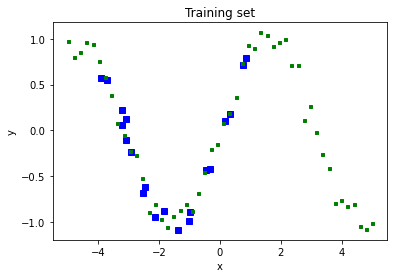

In [2]:
# Noise free/Noisy training data
np.random.seed(42)
nX_tr = 20 # no. of training points
std_y = 1e-1 # if noise free set to 1e-4 for numerical stability; corr. var = 1e-16 addition along diagonal
Xtrain = np.random.uniform(low=-4, high=1, size=(nX_tr,1)).reshape(-1,1) # input
ytrain = np.sin(Xtrain) + std_y*np.random.normal(size=(nX_tr,1)) # output (sin function)

# Test data
nX_te = 50 # no. of test points
Xtest = np.linspace(-5, 5, nX_te).reshape(-1,1) # input
ytest = np.sin(Xtest) + std_y*np.random.normal(size=(nX_te,1)) # output (sin function)

# plot
plt.plot(Xtrain, ytrain, 'bs', ms=6);
plt.plot(Xtest, ytest, 'gs', ms=3);
plt.xlabel('x');
plt.ylabel('y');
plt.title('Training set');

## Kernel function

We will study the squared exponential kernel, which for one-dimensional input reads

$$ k(x,x') =  \sigma_f^2 \exp\left( - \frac{(x-x')^2}{2 l^2} \right) $$

In [3]:
# Kernel function: Squared exponential (SE)
# Param is length scale squared
def se_kern(x, y, sig_f, l_f):
    sqdist = np.sum(x**2,1).reshape(-1,1) + np.sum(y**2,1) - 2*np.dot(x, y.T) # reshape(-1,1): from one-dim. to two-dim. array.
    K = sig_f**2 * np.exp( -0.5 * sqdist / (l_f**2) )
    return(K)

# # test implementation - OK
# def se_kern2(x, y, sig_f, l_f):
#     n1 = x.shape[0]
#     n2 = y.shape[0]
#     K = np.zeros((n1,n2))
#     for i in range(n1):
#         for j in range(n2):
#             K[i,j] = sig_f**2 * np.exp( -0.5 * (x[i]-y[j])**2 / (l_f**2) )
#     return(K)
                    
# kk1=se_kern(Xtrain, ytrain, 1., 2.)
# kk2=se_kern2(Xtrain, ytrain, 1., 2.)
# (np.round(kk1,12)==np.round(kk2,12)).all()

In [4]:
amplitude = 1; length_scale=1
K = se_kern(Xtrain, Xtrain, amplitude, length_scale)
K_s = se_kern(Xtrain, Xtest, amplitude, length_scale)
K_ss = se_kern(Xtest, Xtest, amplitude, length_scale)

## Samples from the prior

We can sample from prior at test points:

$$ f(\mathbf{X}_{\star}) \sim m(\mathbf{X}_{\star}) + \mathbf{L}\mathcal{N}(\boldsymbol0, \mathbf{I}), $$

where $k(\mathbf{X}_{\star},\mathbf{X}_{\star}) = \mathbf{L}^T\mathbf{L}$, i.e. $\mathbf{L}$ may be found by the Cholesky decomposition, and $m(\mathbf{X}_{\star})=0$ may be assumed without loss of generality.

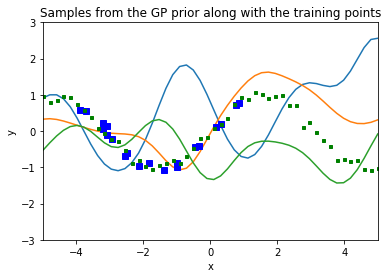

In [5]:
# Get cholesky decomposition (square root) of the
# covariance matrix
eps=1e-8
L_pri = np.linalg.cholesky(K_ss + eps*np.eye(nX_te)) # add a litte jitter for numerical stability

# Sample 3 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
n_samp_pri = 3
f_pri = np.dot(L_pri, np.random.normal(size=(nX_te,n_samp_pri)))

# Now let's plot the 3 sampled functions.
plt.plot(Xtest, f_pri)
plt.plot(Xtrain, ytrain, 'bs', ms=6);
plt.plot(Xtest, ytest, 'gs', ms=3);
plt.xlabel('x');
plt.ylabel('y');
plt.axis([-5, 5, -3, 3])
plt.title('Samples from the GP prior along with the training points');
# plt.show()

## Samples from the posterior

If we condition on the training data, we can also sample from the posterior, as explained in the introduction. We further show the 95\% Bayesian credible interval of the posterior model.

Log marginal likelihood:  [[4.94933208]]


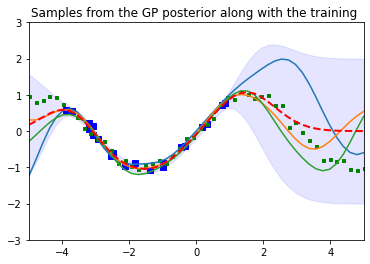

In [6]:
# Apply the kernel function to our training points
L = np.linalg.cholesky(K + np.eye(nX_tr)*std_y**2)

# predictive mean
alp_m = np.linalg.solve(L.T,np.linalg.solve(L, ytrain))
mu_pos = np.dot(K_s.T, alp_m)

# predictive variance
vv_m = np.linalg.solve(L,K_s)
cov_pos = K_ss - vv_m.T.dot(vv_m)
std_pos = (np.diag(cov_pos)**(0.5)).reshape(-1,1) # may need abs as variance is zero at training points (no error), which may be encoded as -0 (no allowed)

# Draw samples from the posterior at our test points.
n_samp_pos = 3
L_pos = np.linalg.cholesky(cov_pos + eps*np.eye(nX_te))
f_pos = mu_pos + np.dot(L_pos, np.random.normal(size=(nX_te,n_samp_pos)))

plt.plot(Xtrain, ytrain, 'bs', ms=6)
plt.plot(Xtest, ytest, 'gs', ms=3);
plt.plot(Xtest, f_pos);
plt.fill_between(x=Xtest[:,0], y1=mu_pos[:,0]-2*std_pos[:,0], y2=mu_pos[:,0]+2*std_pos[:,0], alpha=0.1, color='blue');
plt.plot(Xtest, mu_pos, 'r--', lw=2)
plt.axis([-5, 5, -3, 3]);
plt.title('Samples from the GP posterior along with the training ');
# plt.show()

print('Log marginal likelihood: ', - 0.5 * ytrain.T.dot( alp_m ) - np.sum( np.log( np.diag(L) ) ) 
      - 0.5 * nX_tr * np.log(2*np.pi) )

## Parameter learning: Maximum likelihood estimation using gradient decent

See Rasmussen and Williams (2006) for a reference on MLE for Gaussian processes, and e.g. Bishop(2006; Sec. 3.1.3) or Theodoridis(2020; Sec. 5.1 - 5.4) for a reference on gradient decent.

We will consider how to find a maximum (marginal) likelihood estimate (MLE) of the parameters using gradient decent (GD) - actually we will perform gradient accent as we are maximizing the log likelihood instead of minimizing its negation, as it is common in the optimization literature.

The log $\underline{\text{marginal}}$  likelihood of the data is

$$ \log p(\mathbf{y}|\mathbf{X}) = \log \mathcal{N}(\boldsymbol0, \mathbf{K}_y) = - \frac{1}{2} \mathbf{y}^T \mathbf{K}_y^{-1} \mathbf{y} - \frac{1}{2} \log | \mathbf{K}_y | - \frac{N}{2} \log 2 \pi =  - \frac{1}{2} \mathbf{y}^T \boldsymbol\alpha - \sum_i \log \mathbf{L}_{ii} - \frac{N}{2} \log 2 \pi$$ 

where $\mathbf{K}_y = k(\mathbf{X},\mathbf{X})$, $\boldsymbol\alpha = \mathbf{K}^{-1} \mathbf{y} = ( (\mathbf{L}^{-1})^T (\mathbf{L}^{-1}) ) \mathbf{y}$, and $\mathbf{K} = \mathbf{L}\mathbf{L}^T$ is the Cholesky decomposition. The likelihood is called marginal, as the process $f$ is marginalized out of the expression, i.e. $p(\mathbf{y}|\mathbf{X}) = \int p(\mathbf{y},\mathbf{f}|\mathbf{X}) d\mathbf{f}$.

We will consider two implementations: (i) without re-parametrization, and (ii) with re-parametrization to ensure non-negativity of the kernel parameters through a log-transform. For case (ii) the deviations get a little bit more complicated, as the derivatives should be calculated wrt. e.g. $\theta_1 = \exp(\sigma^2)$, which requires one more pass through the chain rule of differentiation. In case (i) we ignore the non-negativity constraint, as $(-\sigma)^2 = (\sigma)^2$ etc. Thus, parameter space symmetry is explored; as we will see this makes the algorithm less efficient.

***
C. E. Rasmussen, C. K. Williams, Gaussian processes for machine learning, MIT press, 2006.

Bishop, Christopher M. Pattern recognition and machine learning. springer, 2006.

Theodoridis, Sergios. Machine learning: a Bayesian and optimization perspective. Academic Press, 2020.
***

In [7]:
def logMargLike(y, alpha, L, N):
    LML = - 0.5 * y.T.dot( alpha ) - np.sum( np.log( np.diag(L) ) ) - 0.5 * N * np.log(2*np.pi)
    return(LML)

The derivative wrt. a kernel parameter can generally be expressed as

$$ \frac{\partial}{\partial \theta_i} \log p(\mathbf{y}|\mathbf{X}) = \frac{1}{2} \mathbf{y}^T \mathbf{K}_y^{-1} \frac{\partial K_y}{\partial \theta_i} \mathbf{K}_y^{-1} \mathbf{y} - \frac{1}{2} \text{tr} \left( \mathbf{K}_y^{-1} \frac{\partial K_y}{\partial \theta_i} \right) = \frac{1}{2} \text{tr} \left( \left( \boldsymbol\alpha\boldsymbol\alpha^T - \mathbf{K}_y^{-1} \right) \frac{\partial K_y}{\partial \theta_i} \right), $$

which we note to be independent of kernel choice! The kernel that we will explore in this tutorial is the squared exponential kernel, which gives us the following general form for the output kernel (i.e. including the output noise variance):

$$ k_y(\mathbf{x},\mathbf{x}') =  \sigma_f^2 \exp\left( - \frac{1}{2} (\mathbf{x}-\mathbf{x}')^T \mathbf{M} (\mathbf{x}-\mathbf{x}') \right) + \sigma_y^2 \delta_{x,x'}, $$

where $\delta_{x,x'}$ is a delta function that includes $\sigma_y^2$ is the expression only when $\mathbf{x}=\mathbf{x}'$. In the simples formulation, which we will consider here, the matrix $\mathbf{M}=l^{-2}\mathbf{I}$ is isotropic and one-dimensional, as $\mathbf{x}$ is one-dimensional, and thus the expression simplifies to

$$ k_y(x,x') =  \sigma_f^2 \exp\left( - \frac{(x-x')^2}{2 l^2} \right) + \sigma_y^2 \delta_{x,x'}, $$

where the first part corr. the square exponential kernel and the second part corr. the output noise variance of the output observations $\mathbf{y}$.

In [8]:
# Note that se_kern() is defined above
def Ky_kern(x, y, sig_y, sig_f, l_f):
    K = se_kern(x, y, sig_f, l_f)
    Ky = K + np.eye(len(x))*sig_y**2
    return(Ky)

### Implementation without parameter transform

In this implementation we consider the parameter vector: $\boldsymbol\theta = \{\sigma, \sigma_f, l\} $, thus without parameters transformations to ensure that the parameters are non-negative. For the above expression, the gradients ${\partial K_y}/{\partial \theta_i}$ may now be defined:

$$ \frac{\partial K_y}{\partial \sigma_y} = 2 \sigma_y \delta_{x,x'} $$

$$ \frac{\partial K_y}{\partial \sigma_f} = 2 \sigma_f \exp\left( - \frac{(x-x')^2}{2l^2} \right) $$

$$ \frac{\partial K_y}{\partial l} = \sigma_f^2 \exp\left( - \frac{(x-x')^2}{2 l^2} \right) \left( \frac{(x-x')^2}{l^3} \right), $$

where the last expression $\frac{\partial K_y}{\partial l}$ is derived using the chain rule by redefining $K=\sigma_f^2 \exp(g(l))$, thus 

$$ \frac{\partial K_y}{\partial l} = \frac{\partial K_y}{\partial g} \frac{\partial g}{\partial l} = \sigma_f^2 \exp\left( - \frac{(x-x')^2}{2 l^2} \right) \frac{\partial g}{\partial l}, $$

and given that

$$ \frac{\partial g}{\partial l} = \frac{\partial}{\partial l} \left( - \frac{(x-x')^2}{2} l^{-2} \right) = \left( (x-x')^2 l^{-3} \right), $$

we arrive at the expression for $\frac{\partial K_y}{\partial l}$ stated above*. 

***

*The issue of defining expressions for the gradients of the SE kernel is also discussed in this Stack Exchange post:

https://math.stackexchange.com/questions/1030534/gradients-of-marginal-likelihood-of-gaussian-process-with-squared-exponential-co .

***

First, we define a function to calculate the gradient for a general parameter:

$$ \frac{\partial}{\partial \theta_i} \log p(\mathbf{y}|\mathbf{X}) = \frac{1}{2} \text{tr} \left( \left( \boldsymbol\alpha\boldsymbol\alpha^T - \mathbf{K}_y^{-1} \right) \frac{\partial K_y}{\partial \theta_i} \right), $$


In [9]:
def calculate_gradient(alpha, invKy, dKy):
    d_logML = 0.5 * np.trace( (alpha.dot(alpha.T) - invKy).dot( dKy ) )
    return(d_logML)

Next, we define functions to compute the derivative matrices:

$$ \frac{\partial K_y}{\partial \sigma_y} = 2 \sigma_y \delta_{x,x'} $$

In [10]:
def derivative_sig_y(nX, sig_y):
    dKy = 2*sig_y*np.eye(nX)
    return(dKy)

# test implementation - OK
# def derivative_sig_y_numeric(x,y,sig_y,sig_f,l_f):
#     e = 1e-4
#     sig_y_lo = sig_y - e
#     sig_y_hi = sig_y + e
#     dKy = ( Ky_kern(x, y, sig_y_hi, sig_f, l_f) - Ky_kern(x, y, sig_y_lo, sig_f, l_f) ) / (2*e)
#     return(dKy)

# mm1=(derivative_sig_y(nX_tr, 0.1)); print(np.diag(mm1))
# mm2=(derivative_sig_y_numeric(Xtrain,ytrain,0.1,1,2)); print(np.diag(mm2))
# (np.round(mm1,3)==np.round(mm2,3)).all()

$$ \frac{\partial K_y}{\partial \sigma_f} = 2 \sigma_f \exp\left( - \frac{(x-x')^2}{2l^2} \right) $$

In [11]:
def derivative_sig_f(x, sig_f, l_f):
    sqdist = np.sum(x**2,1).reshape(-1,1) + np.sum(x**2,1) - 2*np.dot(x, x.T) # reshape(-1,1): from one-dim. to two-dim. array.
    dKy = 2 * sig_f * np.exp( - sqdist / (2*l_f**2) )
    return(dKy)

# # test implementation ~ OK
# def derivative_sig_f2(x, sig_f, l_f):
#     n = x.shape[0]
#     dKy = np.zeros((n,n))
#     for i in range(n):
#         for j in range(n):
#             dKy[i,j] = 2 * sig_f * np.exp( -0.5 * (x[i]-x[j])**2 / (l_f**2) )
#     return(dKy)

# def derivative_sig_f_numeric(x,y,sig_y,sig_f,l_f):
#     e = 1e-8
#     sig_f_lo = sig_f - e
#     sig_f_hi = sig_f + e
#     dKy = ( Ky_kern(x, y, sig_y, sig_f_hi, l_f) - Ky_kern(x, y, sig_y, sig_f_lo, l_f) ) / (2*e)
#     return(dKy)

# kk1=derivative_sig_f(Xtrain, 1, 2); print(np.diag(kk1))
# kk2=derivative_sig_f_numeric(Xtrain,ytrain, 0.1, 1, 2); print(np.diag(kk2))
# kk3=derivative_sig_f2(Xtrain, 1, 2); print(np.diag(kk3))
# (np.round(kk1,3)==np.round(kk2,3)).all()

$$ \frac{\partial K_y}{\partial l} = \sigma_f^2 \exp\left( - \frac{(x-x')^2}{2 l^2} \right) \left( \frac{(x-x')^2}{l^3} \right), $$

In [12]:
def derivative_l_f(x, sig_f, l_f):
    sqdist = np.sum(x**2,1).reshape(-1,1) + np.sum(x**2,1) - 2*np.dot(x, x.T) # reshape(-1,1): from one-dim. to two-dim. array.
    dKy = sig_f**2 * np.exp(- sqdist / (2*l_f**2) ) * ( sqdist / (l_f**3) )
    return(dKy)

# # test implementation ~ OK
# def derivative_l_f2(x, sig_f, l_f):
#     n = x.shape[0]
#     dKy = np.zeros((n,n))
#     for i in range(n):
#         for j in range(n):
#             dKy[i,j] = sig_f**2 * np.exp( -0.5 * (x[i]-x[j])**2 / (l_f**2) ) * ((x[i]-x[j])**2 / (l_f**3))
#     return(dKy)

# def derivative_l_f_numeric(x,y,sig_y,sig_f,l_f):
#     e = 1e-8
#     l_f_lo = l_f - e
#     l_f_hi = l_f + e
#     dKy = ( Ky_kern(x, y, sig_y, sig_f, l_f_hi) - Ky_kern(x, y, sig_y, sig_f, l_f_lo) ) / (2*e)
#     return(dKy)

# kk1=derivative_l_f(Xtrain, 1, 2); print(np.diag(kk1))
# kk2=derivative_l_f_numeric(Xtrain,ytrain, 0.1, 1, 2); print(np.diag(kk2))
# kk3=derivative_l_f2(Xtrain, 1, 2); print(np.diag(kk3))
# (np.round(kk1,3)==np.round(kk3,3)).all()

#### Initialize the algorithm

Now we are ready to test our implementation, but we first have to initialize the algorithm ...

In [13]:
# initial values for parameters
# sig_y, sig_f, l_f = 0.1, 1, 2
sig_y, sig_f, l_f = 0.05, 2.0, 3.0
# Apply the kernel function to our training points
Ky0 = Ky_kern(Xtrain, Xtrain, sig_y, sig_f, l_f)
Ly0 = np.linalg.cholesky(Ky0)

# inverse of covariance
invLy0 = np.linalg.inv(Ly0)
invKy0 = invLy0.T.dot(invLy0) # invK = invL^T invL

# alpha
alp0 = invKy0.dot(ytrain)

# log marginal likelihood
logM0 = logMargLike(ytrain, alp0, Ly0, nX_tr)

#### Run the optimization

This shows how to run the optimization from óne initialization point; in a real application, we would initialize multiple times overdispersed in the plausible range of the variables and pick the best solution, i.e in terms of likelihood score.

In [14]:
gamma0 = 0.1  # Step size multiplier
precision = 1e-6  # Desired precision of result
max_epochs = 1000  # Maximum number of runs through the training set

for i in range(max_epochs):
    gamma = gamma0 * np.exp(-0.1*i) # temporing
    
    if 0<i:
        invKy0 = invKy1
        alp0 = alp1
        logM0 = logM1
    
    # UPDATA PARAMETERS #####################################
    
    # gradient wrt noise standard deviation
    dKsy = derivative_sig_y(nX_tr, std_y)
    dMsy = calculate_gradient(alp0, invKy0, dKsy)

    # gradient wrt signal standard deviation
    dKsf = derivative_sig_f(Xtrain, sig_f, l_f)
    dMsf = calculate_gradient(alp0, invKy0, dKsf)

    # gradient wrt signal standard deviation
    dKlf = derivative_l_f(Xtrain, sig_f, l_f)
    dMlf = calculate_gradient(alp0, invKy0, dKlf)
    
    # normalize
    dMv = np.array([dMsy, dMsf, dMlf])
    dMv = dMv/np.sqrt(dMv.dot(dMv)) # normalize to unit length (stabalizes the algorithm wrt numerical overfolw)
    
    # Change parameters
    sig_y += gamma * dMv[0] + eps
    sig_f += gamma * dMv[1] + eps
    l_f += gamma * dMv[1] + eps
    
    # DEFINE NEW QUANTITIES AND CALCULATE LOG MARG LIKE##########
    
    # Kernel and decomposition
    Ky1 = Ky_kern(Xtrain, Xtrain, sig_y, sig_f, l_f)
    Ly1 = np.linalg.cholesky(Ky1)

    # inverse of covariance
    invLy1 = np.linalg.inv(Ly1)
    invKy1 = invLy1.T.dot(invLy1) # invK = invL^T invL

    # alpha
    alp1 = invKy1.dot(ytrain)

    # log marginal likelihood
    logM1 = logMargLike(ytrain, alp1, Ly1, nX_tr)
    print(logM1)
    
    if abs( logM1 - logM0 ) <= abs( logM0 ) * precision:
        break

print("Maximum at ", np.array([ sig_y, sig_f, l_f ]), "based on", i, "iterations")
print("Log marginal likelihood:", logM1)

[[2.77013411]]
[[-0.9608564]]
[[3.20527886]]
[[1.59746382]]
[[3.53671006]]
[[2.88814746]]
[[3.78508996]]
[[3.58241088]]
[[3.96872289]]
[[3.97012256]]
[[4.10310872]]
[[4.19054918]]
[[4.20091273]]
[[4.31579337]]
[[4.27219401]]
[[4.38530175]]
[[4.32471267]]
[[4.421622]]
[[4.36409953]]
[[4.43818405]]
[[4.39373476]]
[[4.44340299]]
[[4.41480219]]
[[4.44286338]]
[[4.42762137]]
[[4.44016996]]
[[4.43335194]]
[[4.43706262]]
[[4.43400861]]
[[4.43377302]]
[[4.43162351]]
[[4.42988878]]
[[4.42763276]]
[[4.42527445]]
[[4.4228012]]
[[4.42026544]]
[[4.41783724]]
[[4.41556455]]
[[4.41350051]]
[[4.41163065]]
[[4.40993906]]
[[4.4084086]]
[[4.4070239]]
[[4.40577107]]
[[4.40463755]]
[[4.40361197]]
[[4.40268404]]
[[4.40184446]]
[[4.40108481]]
[[4.40039748]]
[[4.39977557]]
[[4.39921287]]
[[4.39870374]]
[[4.39824306]]
[[4.39782623]]
[[4.39744907]]
[[4.39710781]]
[[4.39679903]]
[[4.39651963]]
[[4.39626683]]
[[4.39603808]]
[[4.39583109]]
[[4.39564381]]
[[4.39547434]]
[[4.395321]]
[[4.39518225]]
[[4.3950567]]
[[4

#### Plot the resulting model

Sample from the posterior and 95\% Bayesian credible interval of the posterior model.

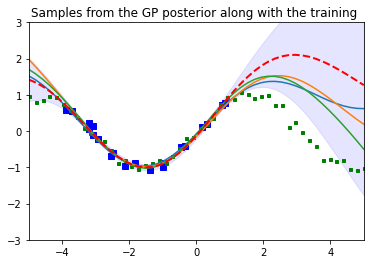

In [15]:
K_s = se_kern(Xtrain, Xtest, sig_f, l_f)
K_ss = se_kern(Xtest, Xtest, sig_f, l_f)

# Apply the kernel function to our training points
Ky = Ky_kern(Xtrain, Xtrain, sig_y, sig_f, l_f)
Ly = np.linalg.cholesky(Ky)

# inverse of covariance
invLy = np.linalg.inv(Ly)
invKy = invLy.T.dot(invLy) # invK = invL^T invL

# alpha
alp_y = invKy.dot(ytrain)

# predictive mean
mu_pos = np.dot(K_s.T, alp_y)

# predictive variance
vv_m = np.linalg.solve(Ly,K_s)
cov_pos = K_ss - vv_m.T.dot(vv_m)
std_pos = (np.diag(cov_pos)**(0.5)).reshape(-1,1) # may need abs as variance is zero at training points (no error), which may be encoded as -0 (no allowed)

# Draw samples from the posterior at our test points.
n_samp_pos = 3
L_pos = np.linalg.cholesky(cov_pos + eps*np.eye(nX_te))
f_pos = mu_pos + np.dot(L_pos, np.random.normal(size=(nX_te,n_samp_pos)))

plt.plot(Xtrain, ytrain, 'bs', ms=6)
plt.plot(Xtest, ytest, 'gs', ms=3);
plt.plot(Xtest, f_pos);
plt.fill_between(x=Xtest[:,0], y1=mu_pos[:,0]-2*std_pos[:,0], y2=mu_pos[:,0]+2*std_pos[:,0], alpha=0.1, color='blue');
plt.plot(Xtest, mu_pos, 'r--', lw=2)
plt.axis([-5, 5, -3, 3]);
plt.title('Samples from the GP posterior along with the training ');
# plt.show()

### Implementation with parameter transform

In this implementation we define the parameter vector: $\boldsymbol\theta = \{\log \sigma^2, \log \sigma_f^2, \log l^2\} $, thus we transform the parameters to ensure that the parameters are non-negative. For the above expression, the gradients ${\partial K_y}/{\partial \theta_i}$ may now be defined:

$$ \frac{\partial K_y}{\partial \theta_1} = \exp(\theta_1) \delta_{x,x'} $$

$$ \frac{\partial K_y}{\partial \theta_2} = \exp(\theta_2) \exp\left( - \frac{(x-x')^2}{2 \exp(\theta_3)} \right) $$

$$ \frac{\partial K_y}{\theta_3} = \exp(\theta_2) \exp\left( - \frac{(x-x')^2}{2 \exp(\theta_3)} \right) \left( \frac{(x-x')^2}{2 \exp(\theta_3)} \right), $$

as $K_y$ i the re-parameterized form reads:

$$ K_y(x,x') =  \exp(\theta_2) \exp\left( - \frac{(x-x')^2}{2 \exp(\theta_3)} \right) + \exp(\theta_1) \delta_{x,x'}, $$

In [16]:
# theta = log sigma_y
def derivative_sig_y_theta1(nX, sig_y):
    dKy = (sig_y**2)*np.eye(nX)
    return(dKy)

# theta = log sigma_f
def derivative_sig_f_theta2(x, sig_f, l_f):
    sqdist = np.sum(x**2,1).reshape(-1,1) + np.sum(x**2,1) - 2*np.dot(x, x.T) # reshape(-1,1): from one-dim. to two-dim. array.
    dKy = (sig_f**2) * np.exp(- sqdist / ( 2 * l_f**2 ) )
    return(dKy)

# theta = log l_f
def derivative_l_f_theta3(x, sig_f, l_f):
    sqdist = np.sum(x**2,1).reshape(-1,1) + np.sum(x**2,1) - 2*np.dot(x, x.T) # reshape(-1,1): from one-dim. to two-dim. array.
    dKy = (sig_f**2) * np.exp(- sqdist / (2*l_f**2) ) * ( sqdist / (2 * l_f**2) )
    return(dKy)

#### Initialize the algorithm

Now we are ready to test our implementation, but we first have to initialize the algorithm ...

In [17]:
# initial values for parameters
sig_y = 0.05; theta1 = np.log(sig_y**2)
sig_f = 2; theta2 = np.log(sig_f**2)
l_f = 3; theta3 = np.log(l_f**2)

# Apply the kernel function to our training points
Ky0 = Ky_kern(Xtrain, Xtrain, sig_y, sig_f, l_f)
Ly0 = np.linalg.cholesky(Ky0)

# inverse of covariance
invLy0 = np.linalg.inv(Ly0)
invKy0 = invLy0.T.dot(invLy0) # invK = invL^T invL

# alpha
alp0 = invKy0.dot(ytrain)

# log marginal likelihood
# logM0 = logMargLike(ytrain, alp0, Ly0, nX_tr)
logM0 = -1e16

#### Run the optimization

This again shows how to run the optimization from óne initialization point; in a real application, we would initialize multiple times overdispersed in the plausible range of the variables and pick the best solution, i.e in terms of likelihood score.

In [18]:
gamma0 = 1  # Step size multiplier
precision = 1e-8  # Desired precision of result
max_epochs = 1000  # Maximum number of runs through the training set

for i in range(max_epochs):
    gamma = gamma0 * np.exp(-0.9*i) # temporing
    
    if 0<i:
        invKy0 = invKy1
        alp0 = alp1
        logM0 = logM1
    
    # UPDATA PARAMETERS #####################################
    
    # gradient wrt theta1 (noise standard deviation)
    dKsy = derivative_sig_y_theta1(nX_tr, std_y)
    dMsy = calculate_gradient(alp0, invKy0, dKsy)

    # gradient wrt theta2 (signal standard deviation)
    dKsf = derivative_sig_f_theta2(Xtrain, sig_f, l_f)
    dMsf = calculate_gradient(alp0, invKy0, dKsf)

    # gradient wrt theta3 (signal length scale)
    dKlf = derivative_l_f_theta3(Xtrain, sig_f, l_f)
    dMlf = calculate_gradient(alp0, invKy0, dKlf)
    
    # Change parameters
    dMtheta = np.array([dMsy, dMsf, dMlf])
    dMtheta = dMtheta/np.sqrt(dMtheta.dot(dMtheta)) # normalize to unit length (stabalizes the algorithm wrt numerical overfolw)
    
    theta1 += gamma * dMtheta[0]
    theta2 += gamma * dMtheta[1]
    theta3 += gamma * dMtheta[2]
    
    sig_y = np.sqrt( np.exp(theta1) ) + eps
    sig_f = np.sqrt( np.exp(theta2) ) + eps
    l_f = np.sqrt( np.exp(theta3) ) + eps
    
    # DEFINE NEW QUANTITIES AND CALCULATE LOG MARG LIKE##########
    
    # Kernel and decomposition
    Ky1 = Ky_kern(Xtrain, Xtrain, sig_y, sig_f, l_f)
    Ly1 = np.linalg.cholesky(Ky1)

    # inverse of covariance
    invLy1 = np.linalg.inv(Ly1)
    invKy1 = invLy1.T.dot(invLy1) # invK = invL^T invL

    # alpha
    alp1 = invKy1.dot(ytrain)

    # log marginal likelihood
    logM1 = logMargLike(ytrain, alp1, Ly1, nX_tr) # without extre regularization (not needed for small dimensiaonal problems, Rasmussen&Williams(2006))
    print(logM1)
    if abs( logM1 - logM0 ) <= abs( logM0 ) * precision:
        break

print("Maximum at ", np.array([ sig_y, sig_f, l_f ]), "based on", i, "iterations")

[[5.84187491]]
[[6.77280165]]
[[6.92041437]]
[[6.98295995]]
[[7.00740403]]
[[7.01722184]]
[[7.02119383]]
[[7.02280548]]
[[7.02346019]]
[[7.02372629]]
[[7.02383447]]
[[7.02387844]]
[[7.02389632]]
[[7.02390359]]
[[7.02390655]]
[[7.02390775]]
[[7.02390824]]
[[7.02390844]]
[[7.02390852]]
[[7.02390855]]
Maximum at  [0.09036608 1.81758084 2.20874715] based on 19 iterations


#### Plot the resulting model

Sample from the posterior and 95\% Bayesian credible interval of the posterior model.

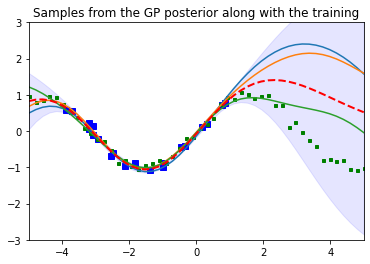

In [19]:
K_s = se_kern(Xtrain, Xtest, sig_f, l_f)
K_ss = se_kern(Xtest, Xtest, sig_f, l_f)

# Apply the kernel function to our training points
Ky = Ky_kern(Xtrain, Xtrain, sig_y, sig_f, l_f)
Ly = np.linalg.cholesky(Ky)

# inverse of covariance
invLy = np.linalg.inv(Ly)
invKy = invLy.T.dot(invLy) # invK = invL^T invL

# alpha
alp_y = invKy.dot(ytrain)

# predictive mean
mu_pos = np.dot(K_s.T, alp_y)

# predictive variance
vv_m = np.linalg.solve(Ly,K_s)
cov_pos = K_ss - vv_m.T.dot(vv_m)
std_pos = (np.diag(cov_pos)**(0.5)).reshape(-1,1) # may need abs as variance is zero at training points (no error), which may be encoded as -0 (no allowed)

# Draw samples from the posterior at our test points.
n_samp_pos = 3
L_pos = np.linalg.cholesky(cov_pos + eps*np.eye(nX_te))
f_pos = mu_pos + np.dot(L_pos, np.random.normal(size=(nX_te,n_samp_pos)))

plt.plot(Xtrain, ytrain, 'bs', ms=6)
plt.plot(Xtest, ytest, 'gs', ms=3);
plt.plot(Xtest, f_pos);
plt.fill_between(x=Xtest[:,0], y1=mu_pos[:,0]-2*std_pos[:,0], y2=mu_pos[:,0]+2*std_pos[:,0], alpha=0.1, color='blue');
plt.plot(Xtest, mu_pos, 'r--', lw=2)
plt.axis([-5, 5, -3, 3]);
plt.title('Samples from the GP posterior along with the training');
# plt.show()

## Parameter learning: Metropolis and Metropolis-Hastings algorithm

See e.g. Gelman et al (2013; ch.11-12) for a reference on the Metropolis and Metropolis-Hastings algorithm.

In this section, we implement the Metropolis and Metropolis-Hastings algorithm, i.e. one implementation considers a symmetric sampling distribution in log-space, and the other use an asymmetric jumping kernel, which is implemented as a Gaussian copula. To consider the one or the other you simply have to uncomment the implementation you want to study and comment out the other one. 

### The generative story

The generative model reads;

$$ p(\theta |\mathcal{D}) \propto p(\mathbf{y}|\mathbf{X},\boldsymbol\theta) p(\boldsymbol\theta), $$

where $$ {\theta_i} =  \text{Inv-Gamma}(a,b), $$

and $\{\theta_i\}_{i=1}^3 = \{ \sigma^2, \sigma_f^2, l^2 \}$. The hyper-parameters $a$ and $b$ are pre-set in this implementation but could also be learnt.

### The unnormalized parameter posterior

Recall that the parameter posterior is defined through Bayes' rule as 

$$p(\boldsymbol\theta|\mathcal{D}) = \frac{ p(\mathbf{y},\boldsymbol\theta|\mathbf{x}) }{ p(\mathbf{y})}, $$

but we will work with the unnormalized version, i.e.

$$p(\boldsymbol\theta|\mathcal{D}) \propto p(\mathbf{y},\boldsymbol\theta|\mathbf{x}), $$

to avoid calculating the always troubling normalizing constant $p(\mathbf{y})$.

***
Gelman, Andrew, et al. Bayesian data analysis. CRC press, 2013.
***

In [20]:
# This function calculates the unnormalized posterior for theta, i.e. p(theta|D) ~ p(y,theta|x)
def log_pos_metropolis(x,y,theta,pam1,pam2,pam3):
    N = x.shape[0]
    sig_y = np.sqrt(theta[0])
    sig_f = np.sqrt(theta[1])
    l_f = np.sqrt(theta[2])
    
    # Apply the kernel function to our training points
    Ky = Ky_kern(x, x, sig_y, sig_f, l_f)
    Ly = np.linalg.cholesky(Ky)

    # inverse of covariance
    invLy = np.linalg.inv(Ly)
    invKy = invLy.T.dot(invLy) # invK = invL^T invL

    # alpha
    alp = invKy.dot(y)

    # log marginal posterior
    logPos = (logMargLike(y, alp, Ly, N) 
              + ss.invgamma(a = pam1[0], scale = pam1[1]).logpdf(theta[0]) 
              + ss.invgamma(a = pam2[0], scale = pam2[1]).logpdf(theta[1]) 
              + ss.invgamma(a = pam3[0], scale = pam3[1]).logpdf(theta[2])
             ) 
    return(logPos)

# log_pos_metropolis(Xtrain, ytrain, np.array([std_y**2, 1**2, 0.1**2]), np.array([3,1]), np.array([3,1]), np.array([3,1]))

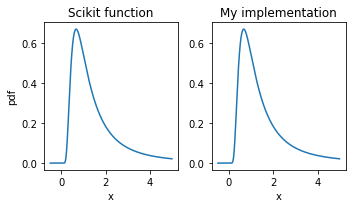

In [21]:
# Make sure we are using the scikit implementation correctly
# https://en.wikipedia.org/wiki/Inverse-gamma_distribution
def my_invgamma_pdf(x,a,b):
    gpdf = np.zeros(len(x))
    ind = (x>0)
    gpdf[ind] = ( (b**a)/math.gamma(a) ) * (1/x[ind])**(a+1) * np.exp( -b/x[ind] )
    return(gpdf)

xx=np.arange(-0.5,5,0.01)
yy1=ss.invgamma.pdf(xx, a=2, scale=2)
yy2=my_invgamma_pdf(xx, 2, 2)

plt.figure(figsize=(5, 3))
plt.subplot(1, 2, 1)
plt.plot(xx,yy1)
plt.xlabel('x')
plt.ylabel('pdf')
plt.title('Scikit function')
plt.subplot(1, 2, 2)
plt.plot(xx,yy2)
plt.title('My implementation')
plt.xlabel('x')
plt.tight_layout()

### Metropolis algorithm

Note that we sample $\log \boldsymbol\theta$ using a Gaussian jumping distribution in this implementation.

#### Sampling from the posterior

This shows how to sample from éne chain; in a real application, we would initialize multiple chains overdispersed in the plausible range of the variables and check for mixing.

In [22]:
# # sigma is assigned an informative prior to keep samples at a realonable level
# pam1 = np.array([2,1/8]); pam2 = np.array([2,2]); pam3 = np.array([2,2]) # choose by CV
# # pam1 = np.array([2,2]); pam2 = np.array([2,2]); pam3 = np.array([2,2])

# np.random.seed(100)
# n_samp_met = 10**3
# eps_met = 1e-8

In [23]:
# # METROPOLIS ALGORITHM

# samp_met = np.zeros([n_samp_met, 3])
# samp_met[0,:] = np.log(np.array([0.01, 1., 2.])**2)
# lp_cur_met = log_pos_metropolis(Xtrain, ytrain, np.exp(samp_met[0,:]), pam1, pam2, pam3)

# proposal_stds = np.abs(samp_met[0,:])*0.05

# counter=0
# for t in range(1,n_samp_met,1):
#     x_pro_met = ss.multivariate_normal( mean = samp_met[t-1,:], cov = (np.diag(proposal_stds) + eps_met) ).rvs(1)
#     lp_pro_met = log_pos_metropolis(Xtrain, ytrain, np.exp(x_pro_met), pam1, pam2, pam3)
    
#     ratio_pro_met = np.min( [(lp_pro_met - lp_cur_met ), 0] )
#     if np.log(np.random.uniform()) < ratio_pro_met: 
#         counter += 1
#         samp_met[t,:] = x_pro_met
#         lp_cur_met = lp_pro_met
#     else:
#         samp_met[t,:] = samp_met[t-1,:]

# samp_met = np.exp(samp_met) # transform back to the scale of sig_y, sig_f, and l_f
# print('Acceptance ratio: ', counter/n_samp_met) 

### Metropolis-Hastings algorithm

Note that we sample from a set of log-normal distributions via a Gaussian copula implementation (see below).

#### Proposal distribution for Metropolis-Hastings algorithm: Gaussian copula representation of log-normal

This is a little overkill for this example, but it builds the foundation for the construction of more complicated jumping distributions, e.g. including covariance information.

In [24]:
def logNorm2Norm_parameters(lm ,ls):
    phi = np.sqrt( ls**2 + lm**2 )
    nm = 2 * np.log(lm) - np.log(phi)  # mean of log(Y) 
    ns = np.sqrt( 2*np.log(phi) - 2*np.log(lm) ) # std dev of log(Y)
    return(nm,ns)
    
# This implementation corresponds to a Gaussian copula, see e.g.
# https://se.mathworks.com/help/stats/copulas-generate-correlated-samples.html
# https://www.sciencedirect.com/science/article/abs/pii/0266892086900330?via%3Dihub
def proposal_distribution(mu_v,sigma_v):
    m = len(mu_v)
    MVN = ss.multivariate_normal( mean = np.zeros(m), cov = np.eye(m) )
    Z = MVN.rvs(1) # define a correlation if needed
    logprobZ = MVN.logpdf(Z) # probability of realization 
    U = ss.norm.cdf(Z)
    X = np.zeros(U.shape)
    for i in range(m):
        nm, ns = logNorm2Norm_parameters(mu_v[i] ,sigma_v[i])
        X[i] = ss.lognorm(s=ns, scale=np.exp(nm)).ppf(U[i]) # define transformation 1
    return(X,logprobZ)

def inv_proposal_distribution(mu_v,sigma_v,x):
    m = len(mu_v)
    U = np.zeros(x.shape)
    for i in range(m):
        nm, ns = logNorm2Norm_parameters(mu_v[i] ,sigma_v[i])
        U[i] = ss.lognorm(s=ns, scale=np.exp(nm)).cdf(x[i]) # define transformation 1
    Z = ss.norm.ppf(U)
    logprob = ss.multivariate_normal( mean = np.zeros(m), cov = np.eye(m) ).logpdf(Z)
    return(logprob)

# xx, llpp = proposal_distribution(np.array([0.1,0.1,0.1]), np.array([1,1,1])); print(xx, llpp)
# llpp2 = inv_proposal_distribution(np.array([0.1,0.1,0.1]), np.array([1,1,1]),xx); print(llpp2)
# uu = np.random.uniform(size=1000000) 
# nnm,nns = logNorm2Norm_parameters(10 ,10)
# xx=ss.lognorm(s=nns, scale=np.exp(nnm)).ppf(uu)

#### Sampling from the posterior

This shows how to sample from éne chain; in a real application, we would initialize multiple chains overdispersed in the plausible range of the variables and check for mixing.

In [25]:
# sigma is assigned an informative prior to keep samples at a realonable level
pam1 = np.array([2,1/8]); pam2 = np.array([2,2]); pam3 = np.array([2,2]) # choose by CV
# pam1 = np.array([2,2]); pam2 = np.array([2,2]); pam3 = np.array([2,2])

np.random.seed(100)
n_samp_met = 10**3
eps_met = 1e-8

In [26]:
# METROPOLIS-HASTINGS ALGORITHM
samp_met = np.zeros([n_samp_met, 3])
samp_met[0,:] = np.array([0.1, 1., 2.])**2 + eps
lp_cur_met = log_pos_metropolis(Xtrain, ytrain, samp_met[0,:], pam1, pam2, pam3)

proposal_stds = samp_met[0,:]*0.15 + eps

counter=0
for t in range(1,n_samp_met,1):
    x_pro_met, logprob_pro_met = proposal_distribution( samp_met[t-1,:] , proposal_stds )
    lp_pro_met = log_pos_metropolis(Xtrain, ytrain, x_pro_met, pam1, pam2, pam3)
    
    logprob_cur_met = inv_proposal_distribution( x_pro_met, proposal_stds , samp_met[t-1,:] )
    
    ratio_pro_met = np.min( [(lp_pro_met - lp_cur_met + logprob_cur_met - logprob_pro_met), 0] ) # log-space formulation
    if np.log(np.random.uniform()) < ratio_pro_met: 
        counter += 1
        samp_met[t,:] = x_pro_met
        lp_cur_met = lp_pro_met
    else:
        samp_met[t,:] = samp_met[t-1,:]

print('Acceptance ratio: ', counter/n_samp_met) 

Acceptance ratio:  0.435


### Analyze samples

We regard the first half of the samples as burn-in, and plot the burn-in samples (red) along with the posterior samples (blue).

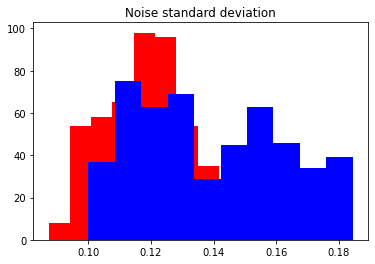

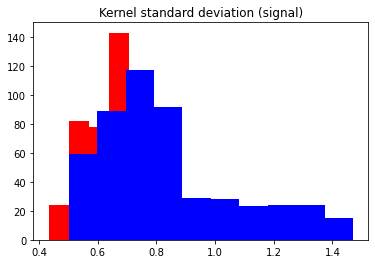

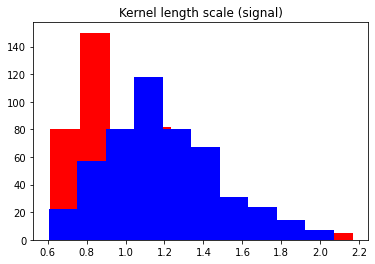

In [27]:
samp_met0 = samp_met[0:round(n_samp_met/2),:] # burn-in
samp_met1 = samp_met[round(n_samp_met/2):n_samp_met,:] # without burn-in

plt.figure()
plt.hist(np.sqrt( samp_met0[:,0]), color='red' );
plt.hist(np.sqrt( samp_met1[:,0]) , color='blue' );
plt.title('Noise standard deviation')

plt.figure()
plt.hist(np.sqrt( samp_met0[:,1]), color='red' );
plt.hist(np.sqrt( samp_met1[:,1]) , color='blue' );
plt.title('Kernel standard deviation (signal)')

plt.figure()
plt.hist(np.sqrt( samp_met0[:,2]), color='red' );
plt.hist(np.sqrt( samp_met1[:,2]) , color='blue' );
plt.title('Kernel length scale (signal)');

### Posterior predictive distribution: Point estimate

Here we pick óne parameter setting for the parameters.

#### Plot the resulting model

Sample from the posterior and 95\% Bayesian credible interval of the posterior model.

[0.12403367 0.51203448 0.83233201]
Log marginal likelihood:  [[3.85841644]]


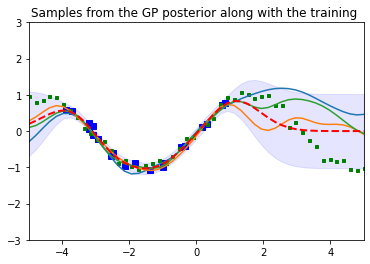

In [28]:
par_est = np.sqrt(ss.mode(samp_met1)[0][0]); print(par_est)
# par_est = np.median(samp_met1, axis=0); print(par_est)
# par_est = np.sqrt(np.mean(samp_met1,axis=0)); print(par_est)

amplitude = par_est[1]; length_scale=par_est[2]
K = se_kern(Xtrain, Xtrain, amplitude, length_scale)
K_s = se_kern(Xtrain, Xtest, amplitude, length_scale)
K_ss = se_kern(Xtest, Xtest, amplitude, length_scale)

# Apply the kernel function to our training points
L = np.linalg.cholesky(K + np.eye(nX_tr)*par_est[0]**2)

# predictive mean
alp_m = np.linalg.solve(L.T,np.linalg.solve(L, ytrain))
mu_pos = np.dot(K_s.T, alp_m)

# predictive variance
vv_m = np.linalg.solve(L,K_s)
cov_pos = K_ss - vv_m.T.dot(vv_m)
std_pos = (np.diag(cov_pos)**(0.5)).reshape(-1,1) # may need abs as variance is zero at training points (no error), which may be encoded as -0 (no allowed)

# Draw samples from the posterior at our test points.
n_samp_pos = 3
L_pos = np.linalg.cholesky(cov_pos + eps*np.eye(nX_te))
f_pos = mu_pos + np.dot(L_pos, np.random.normal(size=(nX_te,n_samp_pos)))

plt.plot(Xtrain, ytrain, 'bs', ms=6)
plt.plot(Xtest, ytest, 'gs', ms=3);
plt.plot(Xtest, f_pos);
plt.fill_between(x=Xtest[:,0], y1=mu_pos[:,0]-2*std_pos[:,0], y2=mu_pos[:,0]+2*std_pos[:,0], alpha=0.1, color='blue');
plt.plot(Xtest, mu_pos, 'r--', lw=2)
plt.axis([-5, 5, -3, 3]);
plt.title('Samples from the GP posterior along with the training ');
# plt.show()

print('Log marginal likelihood: ', - 0.5 * ytrain.T.dot( alp_m ) - np.sum( np.log( np.diag(L) ) ) - 0.5 * nX_tr * np.log(2*np.pi) )

### Posterior predictive distribution: Full Bayesian inference

Here we average over the posterior samples.

#### Evaluate mean function and covariance for all posterior samples

In [29]:
n_samp = samp_met1.shape[0]
m_points = Xtest.shape[0]

mu_pos_samples = np.zeros(( n_samp, m_points )) 
std_pos_samples = np.zeros(( n_samp, m_points )) 

for i in range(n_samp):
    par_vec_i = np.sqrt(samp_met1[i,:])
    
    amplitude = par_vec_i[1]; length_scale=par_vec_i[2]
    K = se_kern(Xtrain, Xtrain, amplitude, length_scale)
    K_s = se_kern(Xtrain, Xtest, amplitude, length_scale)
    K_ss = se_kern(Xtest, Xtest, amplitude, length_scale)
    
    # Apply the kernel function to our training points
    L = np.linalg.cholesky(K + np.eye(nX_tr)*par_vec_i[0]**2)

    # predictive mean
    alp_m = np.linalg.solve(L.T,np.linalg.solve(L, ytrain))
    mu_pos = np.dot(K_s.T, alp_m)

    # predictive variance
    vv_m = np.linalg.solve(L,K_s)
    cov_pos = K_ss - vv_m.T.dot(vv_m)
    std_pos = (np.diag(cov_pos)**(0.5)).reshape(-1,1)
    
    mu_pos_samples[i,:] = mu_pos.T
    std_pos_samples[i,:] = std_pos.T

#### Define sample statistics for the latent function (f) and the output (y)

In [30]:
# Define sample statistics for the latent function (f) and the output (y)
f_stats = np.zeros((m_points,3))
y_stats = np.zeros((m_points,3))
noise_y = np.random.normal(np.zeros(n_samp))
for i in range(m_points):
    f_samp_i = mu_pos_samples[:,i]
    f_samp_i_m = np.mean(f_samp_i)
    f_samp_i_q = np.quantile(f_samp_i, [0.025, 0.975])
    f_stats[i,:] = np.concatenate(([f_samp_i_m],f_samp_i_q), axis=0)
    
    y_samp_i = mu_pos_samples[:,i] + noise_y * std_pos_samples[:,i]
    y_samp_i_m = np.mean(y_samp_i)
    y_samp_i_q = np.quantile(y_samp_i, [0.025, 0.975])
    y_stats[i,:] = np.concatenate(([y_samp_i_m],y_samp_i_q), axis=0)

#### Plot the resulting model

95\% Bayesian credible interval of the posterior model.

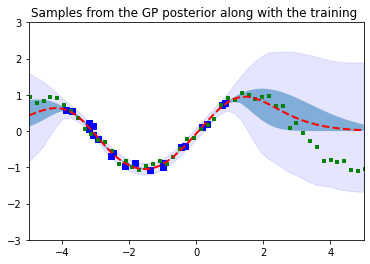

In [31]:
# Plot training and test data
plt.plot(Xtrain, ytrain, 'bs', ms=6)
plt.plot(Xtest, ytest, 'gs', ms=3);
# Predictive mean
plt.plot(Xtest, f_stats[:,0], 'r--', lw=2)
# Shade in credible region
plt.fill_between(Xtest[:,0], y_stats[:,1], y_stats[:,2], alpha=0.1, color='blue')
plt.fill_between(Xtest[:,0], f_stats[:,1], f_stats[:,2], alpha=0.5)
plt.axis([-5, 5, -3, 3]);
plt.title('Samples from the GP posterior along with the training ');

## Parameter learning: Hamiltonian Monte Carlo algorithm

See e.g. Gelman et al. (2013; Sec.12.4 and App.C.4 (R implementation)) for a reference on the Hamiltonian Monte Carlo algorithm.

### The generative story

In this section, we will use a log-normal proposal distribution (non-symmetric) and the following generative model in the MCMC of Metropolis-Hastings;

$$ p(\theta |\mathcal{D}) \propto p(\mathbf{y}|\mathbf{X},\boldsymbol\theta) p(\boldsymbol\theta), $$

where $$ {\theta_i}^2 =  \text{Inv-Gamma}(a,b), $$

and $\{\theta_i\}_{i=1}^3 = \{ \sigma, \sigma_f, l \}$, with the hyper-parameters $a$ and $b$ pre-set in this implementation. Thus, we will parameterize the model as we did when performing MLE above (without parameters transformations), in order to reuse some of the functions already implemented. We could also for this case consider a parameter transformation, and define the probabilistic model in the transformed space using the Jacobien, see Gelman et al.(2013).

### The unnormalized parameter posterior

Recall that the parameter posterior is defined through Bayes' rule as 

$$p(\boldsymbol\theta|\mathcal{D}) = \frac{ p(\mathbf{y},\boldsymbol\theta|\mathbf{x}) }{ p(\mathbf{y})}, $$

but we will work with the unnormalized version, i.e.

$$p(\boldsymbol\theta|\mathcal{D}) \propto p(\mathbf{y},\boldsymbol\theta|\mathbf{x}), $$

to avoid calculating the always troubling normalizing constant $\mathbf{y}$.

***
Gelman, Andrew, et al. Bayesian data analysis. CRC press, 2013.
***

In [32]:
# This function calculates the unnormalized posterior for theta, i.e. p(theta|D) = p(y,theta|x)/p(y)
def log_pos_hmc(x,y,theta,pam1,pam2,pam3):
    
    if (np.any(np.isnan(theta))):
        logPos = -1e-16
    elif (np.any(theta <= 0)):
        logPos = -1e-16
    else:
        N = x.shape[0]
        sig_y = theta[0]
        sig_f = theta[1]
        l_f = theta[2]

        # Apply the kernel function to our training points
        Ky = Ky_kern(x, x, sig_y, sig_f, l_f)
        Ly = np.linalg.cholesky(Ky)

        # inverse of covariance
        invLy = np.linalg.inv(Ly)
        invKy = invLy.T.dot(invLy) # invK = invL^T invL

        # alpha
        alp = invKy.dot(y)

        # log marginal posterior
        logPos = (logMargLike(y, alp, Ly, N) 
                  + ss.invgamma(a = pam1[0], scale = pam1[1]).logpdf(theta[0]**2) 
                  + ss.invgamma(a = pam2[0], scale = pam2[1]).logpdf(theta[1]**2) 
                  + ss.invgamma(a = pam3[0], scale = pam3[1]).logpdf(theta[2]**2)
                 ) 
    return(logPos)

# log_pos_hmc(Xtrain, ytrain, np.array([std_y, 1, 2]), np.array([2,2]), np.array([2,2]), np.array([2,2]))
# log_pos_hmc(Xtrain, ytrain, np.array([std_y, np.nan, 2]), np.array([2,2]), np.array([2,2]), np.array([2,2]))
# log_pos_hmc(Xtrain, ytrain, np.array([std_y, -1, 2]), np.array([2,2]), np.array([2,2]), np.array([2,2]))

### Gradients of the posterior model

As note we can re-use the gradients already derived for the likelihood part, so we simply have to define the gradients for the inverse gamma terms and combine the likelihood and prior terms. 

#### Gradients of inverse gamma

In [33]:
def my_invgamma_gradient_x(x,a,b):
    grad = -2*(a+1) / x + 2 * b * x**(-3)  
    return(grad)

# Test implementation
# def my_invgamma_gradient_numerical(x,a,b):
#     e = 1e-4
#     x_lo = x**2 - e
#     x_hi = x**2 + e
#     grad = ( np.log(my_invgamma_pdf(x_hi, a, b) ) - np.log( my_invgamma_pdf(x_lo, a, b) ) ) / (2*e)
#     return(grad)
#
# # Test
# xtt = np.array([0.5])
# print( my_invgamma_gradient_x2(xtt,2,2) )
# print( my_invgamma_gradient_numerical(xtt,2,2) )

#### Gradients of parameter posterior

In [34]:
def hmc_gradients(x,y,theta,pam1,pam2,pam3):
    nX = x.shape[0]
    
    Ky = Ky_kern(x, x, theta[0], theta[1], theta[2]) + np.eye(nX)*1e-8
    Ly = np.linalg.cholesky(Ky)
    invLy = np.linalg.inv(Ly)
    invKy = invLy.T.dot(invLy) # invK = invL^T invL
    alp = invKy.dot(y)
    
    # gradient wrt noise standard deviation
    dKsy = derivative_sig_y(nX, theta[0]) 
    dMsy = calculate_gradient(alp, invKy, dKsy) + my_invgamma_gradient_x(theta[0],pam1[0],pam1[1])
    
    # gradient wrt signal standard deviation
    dKsf = derivative_sig_f(x, theta[1], theta[2]) 
    dMsf = calculate_gradient(alp, invKy, dKsf) + my_invgamma_gradient_x(theta[1],pam2[0],pam2[1])
    
    # gradient wrt signal standard deviation
    dKlf = derivative_l_f(x, theta[1], theta[2]) 
    dMlf = calculate_gradient(alp, invKy, dKlf) + my_invgamma_gradient_x(theta[2],pam3[0],pam3[1])
    
    dMtheta = np.array([dMsy, dMsf, dMlf])
    return(dMtheta)

# Test implementation - OK
def hmc_gradients_numeric(x,y,theta,pam1,pam2,pam3):
    d = len(theta)
    e = 1e-4
    grad = np.zeros(d)
    for i in range(d):
        th_lo = theta.copy(); 
        th_hi = theta.copy(); 
        th_lo[i] -= e; 
        th_hi[i] += e; 
        
        grad[i] = ( log_pos_hmc(x,y,th_hi,pam1,pam2,pam3) - log_pos_hmc(x,y,th_lo,pam1,pam2,pam3) ) / (2*e)
    return(grad)

print(hmc_gradients(Xtrain, ytrain, np.array([0.1, 1., 2.]), np.array([2,2]), np.array([2,2]), np.array([2,2])))
print(hmc_gradients_numeric(Xtrain, ytrain, np.array([0.1, 1., 2.]), np.array([2,2]), np.array([2,2]), np.array([2,2])))

[ 3.91239156e+03  9.04441012e-02 -4.83252533e+00]
[ 3.91239984e+03  9.04443554e-02 -4.83252563e+00]


### Sampling from the posterior

This shows how to sample from éne chain; in a real application, we would initialize multiple chains overdispersed in the plausible range of the variables and check for mixing.

#### Function implementing óne HMC iteration

In [35]:
# One HMC iteration
def hmc_iteration(x,y,theta,pam1,pam2,pam3,epsilon,nLeap,M):
    M_inv = 1/M
    d = len(theta)
    
    # initialize
    phi = np.random.normal(loc=np.zeros(d), scale=np.sqrt(M))
    theta0 = theta.copy()
    
    # log posterior
    log_pos0 = log_pos_hmc(x,y,theta,pam1,pam2,pam3) - 0.5*np.sum(M_inv*phi**2)
    
    # leapfrog steps
    phi += 0.5*epsilon*hmc_gradients(x,y,theta,pam1,pam2,pam3)
    for l in range(nLeap):
        theta += epsilon*M_inv*phi
        if (l==(nLeap-1)):
            phi += 0.5*epsilon*hmc_gradients(x,y,theta,pam1,pam2,pam3)
        else:
            phi += 1.0*epsilon*hmc_gradients(x,y,theta,pam1,pam2,pam3)
    
    # Metropolis step
    log_pos1 = log_pos_hmc(x,y,theta,pam1,pam2,pam3) - 0.5*np.sum(M_inv*phi**2)
    ratio = np.min( [(log_pos1 - log_pos0 ), 0] )
    if np.log(np.random.uniform()) < ratio: 
        theta1 = theta
        counter = 1
    else:
        theta1 = theta0
        counter = 0
    
    return(theta1, counter)

# hmc_iteration(Xtrain,ytrain,np.array([0.1, 1., 2.]),np.array([2,2]),np.array([2,2]),np.array([2,2]),0.001, 3, np.ones(3))

#### Sampling from the posterior - one chain wrapper for the function above

In [36]:
np.random.seed(100)
n_samp_hmc = 10**3
epsilon0 = 0.1
nLeap0 = 10
eps = 1e-8

samp_hmc = np.zeros([n_samp_hmc, 3])
samp_hmc[0,:] = np.array([0.1, 1., 2.]) + eps
mass_vec = 1/(2*samp_hmc[0,:]**2) + eps

counter = 0
for t in range(1,n_samp_hmc,1):
    th_t, count_t = hmc_iteration(Xtrain, ytrain, 
                                  samp_hmc[t-1,:], 
                                  np.array([2,1/8]), np.array([2,2]), np.array([2,2]), 
                                  epsilon0, nLeap0 , mass_vec)
    samp_hmc[t,:] = th_t.copy()
    counter += count_t
    
print('Acceptance rate: ', counter/n_samp_hmc) # Gelman (2013) recommend ~60-70% for HMC 

Acceptance rate:  0.633


### Analyze samples

We regard the first half of the samples as burn-in and plot the posterior samples (blue).

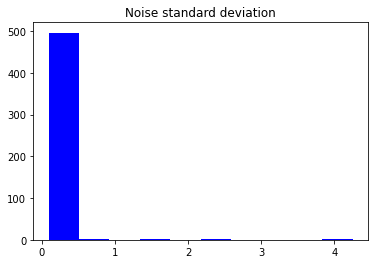

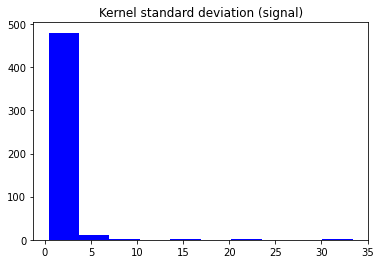

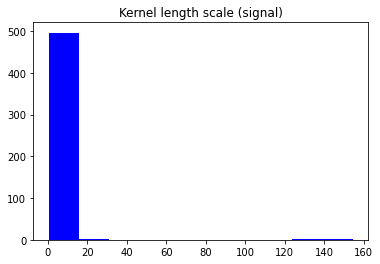

In [37]:
samp_hmc0 = samp_hmc[0:round(n_samp_hmc/2),:] # burn-in
samp_hmc1 = samp_hmc[round(n_samp_hmc/2):n_samp_hmc,:] # without burn-in

plt.figure()
# plt.hist(samp_hmc0[:,0], color='red' );
plt.hist(samp_hmc1[:,0] , color='blue' );
plt.title('Noise standard deviation')

plt.figure()
# plt.hist(samp_hmc0[:,1], color='red' );
plt.hist(samp_hmc1[:,1] , color='blue' );
plt.title('Kernel standard deviation (signal)')

plt.figure()
# plt.hist(samp_hmc0[:,2], color='red' );
plt.hist(samp_hmc1[:,2] , color='blue' );
plt.title('Kernel length scale (signal)');

### Posterior predictive distribution: Point estimate

Here we pick óne parameter setting for the parameters.

#### Plot the resulting model

Sample from the posterior and 95\% Bayesian credible interval of the posterior model.

[0.14672252 0.77689273 1.76872226]
Log marginal likelihood:  [[4.47022595]]


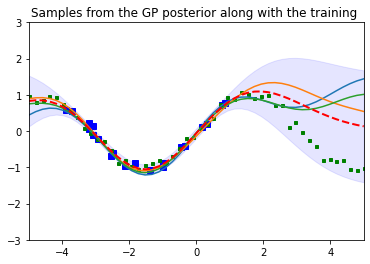

In [38]:
par_est = (ss.mode(samp_hmc1)[0][0]); print(par_est)

amplitude = par_est[1]; length_scale=par_est[2]
K = se_kern(Xtrain, Xtrain, amplitude, length_scale)
K_s = se_kern(Xtrain, Xtest, amplitude, length_scale)
K_ss = se_kern(Xtest, Xtest, amplitude, length_scale)

# Apply the kernel function to our training points
L = np.linalg.cholesky(K + np.eye(nX_tr)*par_est[0]**2)

# predictive mean
alp_m = np.linalg.solve(L.T,np.linalg.solve(L, ytrain))
mu_pos = np.dot(K_s.T, alp_m)

# predictive variance
vv_m = np.linalg.solve(L,K_s)
cov_pos = K_ss - vv_m.T.dot(vv_m)
std_pos = (np.diag(cov_pos)**(0.5)).reshape(-1,1) # may need abs as variance is zero at training points (no error), which may be encoded as -0 (no allowed)

# Draw samples from the posterior at our test points.
n_samp_pos = 3
L_pos = np.linalg.cholesky(cov_pos + eps*np.eye(nX_te))
f_pos = mu_pos + np.dot(L_pos, np.random.normal(size=(nX_te,n_samp_pos)))

plt.plot(Xtrain, ytrain, 'bs', ms=6)
plt.plot(Xtest, ytest, 'gs', ms=3);
plt.plot(Xtest, f_pos);
plt.fill_between(x=Xtest[:,0], y1=mu_pos[:,0]-2*std_pos[:,0], y2=mu_pos[:,0]+2*std_pos[:,0], alpha=0.1, color='blue');
plt.plot(Xtest, mu_pos, 'r--', lw=2)
plt.axis([-5, 5, -3, 3]);
plt.title('Samples from the GP posterior along with the training ');
# plt.show()

print('Log marginal likelihood: ', - 0.5 * ytrain.T.dot( alp_m ) - np.sum( np.log( np.diag(L) ) ) - 0.5 * nX_tr * np.log(2*np.pi) )

### Posterior predictive distribution: Full Bayesian inference

Here we average over the posterior samples.

#### Evaluate mean function and covariance for all posterior samples

In [39]:
n_samp = samp_hmc1.shape[0]
m_points = Xtest.shape[0]

mu_pos_samples = np.zeros(( n_samp, m_points )) 
std_pos_samples = np.zeros(( n_samp, m_points )) 

for i in range(n_samp):
    par_vec_i = samp_hmc1[i,:]
    
    amplitude = par_vec_i[1]; length_scale=par_vec_i[2]
    K = se_kern(Xtrain, Xtrain, amplitude, length_scale)
    K_s = se_kern(Xtrain, Xtest, amplitude, length_scale)
    K_ss = se_kern(Xtest, Xtest, amplitude, length_scale)
    
    # Apply the kernel function to our training points
    L = np.linalg.cholesky(K + np.eye(nX_tr)*par_vec_i[0]**2)

    # predictive mean
    alp_m = np.linalg.solve(L.T,np.linalg.solve(L, ytrain))
    mu_pos = np.dot(K_s.T, alp_m)

    # predictive variance
    vv_m = np.linalg.solve(L,K_s)
    cov_pos = K_ss - vv_m.T.dot(vv_m)
    std_pos = (np.diag(cov_pos)**(0.5)).reshape(-1,1)
    
    mu_pos_samples[i,:] = mu_pos.T
    std_pos_samples[i,:] = std_pos.T

#### Define sample statistics for the latent function (f) and the output (y)

In [40]:
f_stats = np.zeros((m_points,3))
y_stats = np.zeros((m_points,3))
noise_y = np.random.normal(np.zeros(n_samp))
for i in range(m_points):
    f_samp_i = mu_pos_samples[:,i]
    f_samp_i_m = np.mean(f_samp_i)
#     f_samp_i_m = np.quantile(f_samp_i, 0.5)
    f_samp_i_q = np.quantile(f_samp_i, [0.025, 0.975])
    f_stats[i,:] = np.concatenate(([f_samp_i_m],f_samp_i_q), axis=0)
    
    y_samp_i = mu_pos_samples[:,i] + noise_y * std_pos_samples[:,i]
    y_samp_i_m = np.mean(y_samp_i)
#     y_samp_i_m = np.quantile(y_samp_i, 0.5)
    y_samp_i_q = np.quantile(y_samp_i, [0.025, 0.975])
    y_stats[i,:] = np.concatenate(([y_samp_i_m],y_samp_i_q), axis=0)

#### Plot the resulting model

95\% Bayesian credible interval of the posterior model.

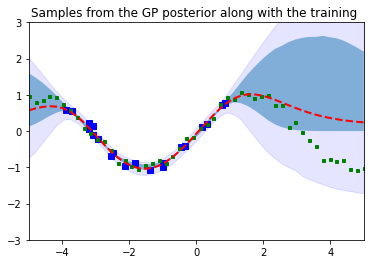

In [41]:
# Plot training and test data
plt.plot(Xtrain, ytrain, 'bs', ms=6)
plt.plot(Xtest, ytest, 'gs', ms=3);
# Predictive mean
plt.plot(Xtest, f_stats[:,0], 'r--', lw=2)
# Shade in credible region
plt.fill_between(Xtest[:,0], y_stats[:,1], y_stats[:,2], alpha=0.1, color='blue')
plt.fill_between(Xtest[:,0], f_stats[:,1], f_stats[:,2], alpha=0.5)
plt.axis([-5, 5, -3, 3]);
plt.title('Samples from the GP posterior along with the training ');

## Parameter learning: GPy with MLE

Now that we have considered how it works, we are allowed to cheat with the GPy library... 

### GPy model

In [42]:
# Make a GP regression model
model = GPy.models.GPRegression(Xtrain,ytrain); # define model
model.optimize_restarts(num_restarts = 10); # optimize
display(model); # display resulting model

Optimization restart 1/10, f = -7.572121777524444
Optimization restart 2/10, f = -7.572121777533287
Optimization restart 3/10, f = -7.57212177753159
Optimization restart 4/10, f = -7.572121776356104
Optimization restart 5/10, f = -7.5721217775312635
Optimization restart 6/10, f = -7.5721217775293805
Optimization restart 7/10, f = -7.5721217775339085
Optimization restart 8/10, f = -7.572121777055045
Optimization restart 9/10, f = -7.572121777526672
Optimization restart 10/10, f = -7.572121777534129


GP_regression.,value,constraints,priors
rbf.variance,1.1302989693531467,+ve,
rbf.lengthscale,1.8176776367925433,+ve,
Gaussian_noise.variance,0.00807592034811161,+ve,


### Plot the resulting model

Sample from the posterior and 95\% Bayesian credible interval of the posterior model.

[0.08986612 1.0631552  1.81767764]
Log marginal likelihood:  [[7.57212178]]


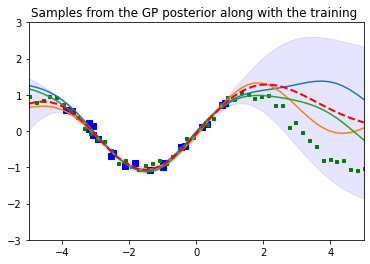

In [43]:
sig_y, sig_f, l_f = np.sqrt(model.Gaussian_noise.variance[0]), np.sqrt(model.rbf.variance[0]), model.rbf.lengthscale[0]
print( np.array([sig_y, sig_f, l_f]) )
K_s = se_kern(Xtrain, Xtest, sig_f, l_f)
K_ss = se_kern(Xtest, Xtest, sig_f, l_f)

# Apply the kernel function to our training points
Ky = Ky_kern(Xtrain, Xtrain, sig_y, sig_f, l_f)
Ly = np.linalg.cholesky(Ky)

# inverse of covariance
invLy = np.linalg.inv(Ly)
invKy = invLy.T.dot(invLy) # invK = invL^T invL

# alpha
alp_y = invKy.dot(ytrain)

# predictive mean
mu_pos = np.dot(K_s.T, alp_y)

# predictive variance
vv_m = np.linalg.solve(Ly,K_s)
cov_pos = K_ss - vv_m.T.dot(vv_m)
std_pos = (np.diag(cov_pos)**(0.5)).reshape(-1,1) # may need abs as variance is zero at training points (no error), which may be encoded as -0 (no allowed)

# Draw samples from the posterior at our test points.
n_samp_pos = 3
L_pos = np.linalg.cholesky(cov_pos + eps*np.eye(nX_te))
f_pos = mu_pos + np.dot(L_pos, np.random.normal(size=(nX_te,n_samp_pos)))

plt.plot(Xtrain, ytrain, 'bs', ms=6)
plt.plot(Xtest, ytest, 'gs', ms=3);
plt.plot(Xtest, f_pos);
plt.fill_between(x=Xtest[:,0], y1=mu_pos[:,0]-2*std_pos[:,0], y2=mu_pos[:,0]+2*std_pos[:,0], alpha=0.1, color='blue');
plt.plot(Xtest, mu_pos, 'r--', lw=2)
plt.axis([-5, 5, -3, 3]);
plt.title('Samples from the GP posterior along with the training ');
# plt.show()

print('Log marginal likelihood: ', - 0.5 * ytrain.T.dot( alp_y ) - np.sum( np.log( np.diag(Ly) ) ) - 0.5 * nX_tr * np.log(2*np.pi) )

## Parameter learning: GPy with HMC inference

### The generative story

In this section, we will use the following generative model in the HMC implementation;

$$ p(\theta |\mathcal{D}) \propto p(\mathbf{y}|\mathbf{X},\boldsymbol\theta) p(\boldsymbol\theta), $$

where $$ {\theta_i} =  \text{Inv-Gamma}(2,2), $$

and $\{\theta_i\}_{i=1}^3 = \{ \sigma^2, \sigma_f, l^2 \}$.

### GPy model

In [44]:
# Make a GP regression model
model = GPy.models.GPRegression(Xtrain,ytrain)
# Give some general prior distributions for model parameters
model.kern.lengthscale.set_prior(GPy.priors.Gamma(2,1/2))
model.kern.variance.set_prior(GPy.priors.Gamma(2,1/2))
model.likelihood.variance.set_prior(GPy.priors.Gamma(2,1/2))
print(model)

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance



Name : GP regression
Objective : 29.86312658286688
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |    priors  
  rbf.variance             |    1.0  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |    1.0  |      +ve      |  Ga(2, 0.5)
  Gaussian_noise.variance  |    1.0  |      +ve      |  Ga(2, 0.5)


### Sampling from the posterior distribution of model parameters

This shows how to sample from éne chain; in a real application, we would initialize multiple chains overdispersed in the plausible range of the variables and check for mixing.

In [45]:
hmc = GPy.inference.mcmc.HMC(model,stepsize=1e-1)
hmc_samp = hmc.sample(num_samples=1000)

### Analyze samples

We regard the first half of the samples as burn-in and plot the posterior samples (blue).

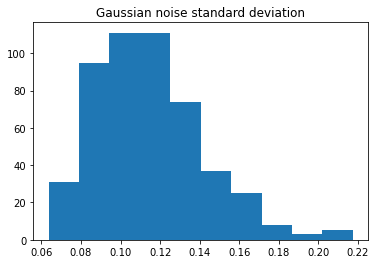

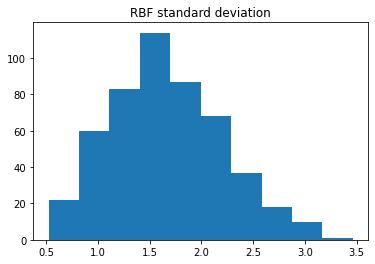

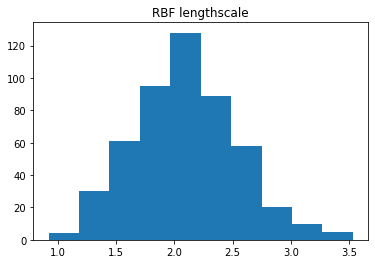

In [46]:
samples = hmc_samp[500:] # cut out the burn-in period
my_ind = [2,0,1] # my indexing
samples = samples[:,my_ind] # redefine samples with my indexing

plt.figure()
plt.hist(np.sqrt( samples[:,0] ));
plt.title('Gaussian noise standard deviation');

plt.figure()
plt.hist(np.sqrt( samples[:,1] ));
plt.title('RBF standard deviation');

plt.figure()
plt.hist( samples[:,2] );
plt.title('RBF lengthscale');

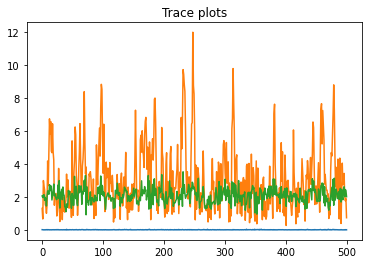

In [47]:
plt.plot(samples);
plt.title('Trace plots');

### Posterior predictive distribution: Point estimate

Here we pick óne parameter setting for the parameters.

#### Plot the resulting model

Sample from the posterior and 95\% Bayesian credible interval of the posterior model.

[0.07522955 1.38034057 1.72739235]
Log marginal likelihood:  [[6.71211972]]


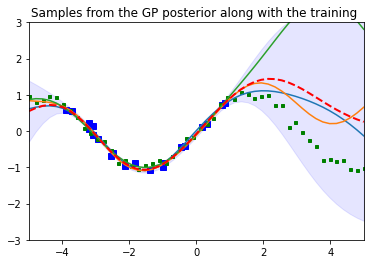

In [48]:
# define parameters vector, as use above
par_est = (ss.mode(samples)[0][0]); 
par_est[0:2] = np.sqrt(par_est[0:2]); print(par_est)

amplitude = par_est[1]; length_scale=par_est[2]
K = se_kern(Xtrain, Xtrain, amplitude, length_scale)
K_s = se_kern(Xtrain, Xtest, amplitude, length_scale)
K_ss = se_kern(Xtest, Xtest, amplitude, length_scale)

# Apply the kernel function to our training points
L = np.linalg.cholesky(K + np.eye(nX_tr)*par_est[0]**2)

# predictive mean
alp_m = np.linalg.solve(L.T,np.linalg.solve(L, ytrain))
mu_pos = np.dot(K_s.T, alp_m)

# predictive variance
vv_m = np.linalg.solve(L,K_s)
cov_pos = K_ss - vv_m.T.dot(vv_m)
std_pos = (np.diag(cov_pos)**(0.5)).reshape(-1,1) # may need abs as variance is zero at training points (no error), which may be encoded as -0 (no allowed)

# Draw samples from the posterior at our test points.
n_samp_pos = 3
L_pos = np.linalg.cholesky(cov_pos + eps*np.eye(nX_te))
f_pos = mu_pos + np.dot(L_pos, np.random.normal(size=(nX_te,n_samp_pos)))

plt.plot(Xtrain, ytrain, 'bs', ms=6)
plt.plot(Xtest, ytest, 'gs', ms=3);
plt.plot(Xtest, f_pos);
plt.fill_between(x=Xtest[:,0], y1=mu_pos[:,0]-2*std_pos[:,0], y2=mu_pos[:,0]+2*std_pos[:,0], alpha=0.1, color='blue');
plt.plot(Xtest, mu_pos, 'r--', lw=2)
plt.axis([-5, 5, -3, 3]);
plt.title('Samples from the GP posterior along with the training ');
# plt.show()

print('Log marginal likelihood: ', - 0.5 * ytrain.T.dot( alp_m ) - np.sum( np.log( np.diag(L) ) ) - 0.5 * nX_tr * np.log(2*np.pi) )

### Posterior predictive distribution: Full Bayesian inference

Here we average over the posterior samples.

#### Evaluate mean function and covariance for all posterior samples

In [49]:
samples[:,0:2] = np.sqrt( samples[:,0:2] )
n_samp = samples.shape[0]
m_points = Xtest.shape[0]

mu_pos_samples = np.zeros(( n_samp, m_points )) 
std_pos_samples = np.zeros(( n_samp, m_points )) 

for i in range(n_samp):
    par_vec_i = samples[i,:]
    
    amplitude = par_vec_i[1]; length_scale=par_vec_i[2]
    K = se_kern(Xtrain, Xtrain, amplitude, length_scale)
    K_s = se_kern(Xtrain, Xtest, amplitude, length_scale)
    K_ss = se_kern(Xtest, Xtest, amplitude, length_scale)
    
    # Apply the kernel function to our training points
    L = np.linalg.cholesky(K + np.eye(nX_tr)*par_vec_i[0]**2)

    # predictive mean
    alp_m = np.linalg.solve(L.T,np.linalg.solve(L, ytrain))
    mu_pos = np.dot(K_s.T, alp_m)

    # predictive variance
    vv_m = np.linalg.solve(L,K_s)
    cov_pos = K_ss - vv_m.T.dot(vv_m)
    std_pos = (np.diag(cov_pos)**(0.5)).reshape(-1,1)
    
    mu_pos_samples[i,:] = mu_pos.T
    std_pos_samples[i,:] = std_pos.T

#### Define sample statistics for the latent function (f) and the output (y)

In [50]:
f_stats = np.zeros((m_points,3))
y_stats = np.zeros((m_points,3))
noise_y = np.random.normal(np.zeros(n_samp))
for i in range(m_points):
    f_samp_i = mu_pos_samples[:,i]
    f_samp_i_m = np.mean(f_samp_i)
#     f_samp_i_m = np.quantile(f_samp_i, 0.5)
    f_samp_i_q = np.quantile(f_samp_i, [0.025, 0.975])
    f_stats[i,:] = np.concatenate(([f_samp_i_m],f_samp_i_q), axis=0)
    
    y_samp_i = mu_pos_samples[:,i] + noise_y * std_pos_samples[:,i]
    y_samp_i_m = np.mean(y_samp_i)
#     y_samp_i_m = np.quantile(y_samp_i, 0.5)
    y_samp_i_q = np.quantile(y_samp_i, [0.025, 0.975])
    y_stats[i,:] = np.concatenate(([y_samp_i_m],y_samp_i_q), axis=0)

#### Plot the resulting model

95\% Bayesian credible interval of the posterior model.

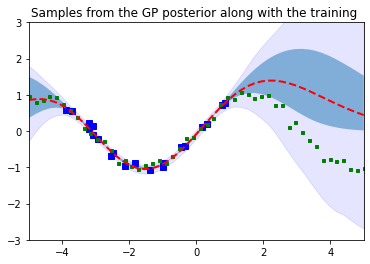

In [51]:
# Plot training and test data
plt.plot(Xtrain, ytrain, 'bs', ms=6)
plt.plot(Xtest, ytest, 'gs', ms=3);
# Predictive mean
plt.plot(Xtest, f_stats[:,0], 'r--', lw=2)
# Shade in credible region
plt.fill_between(Xtest[:,0], y_stats[:,1], y_stats[:,2], alpha=0.1, color='blue')
plt.fill_between(Xtest[:,0], f_stats[:,1], f_stats[:,2], alpha=0.5)
plt.axis([-5, 5, -3, 3]);
plt.title('Samples from the GP posterior along with the training ');

# Multi-output Gaussian Process Regression

See Alvarez et al. (2012) for a reference on multi-output Gaussian processes.

## The model

In this section, the framework presented in the foregoing section is extended to cover multi-output processes, thus the available data set for this case is $\mathcal{D}=\{ \mathbf{X}, \mathbf{Y} \} = \{ \mathbf{x}[n], \mathbf{y}[n] \}_{n=1}^N$, where both the inputs and outputs are vector-valued. Furthermore, in the further treatment, it is assumed that all inputs are applied in the regression for all outputs.

In multi-output learning the output space is a vector space, thus leading to a vector-valued estimator $\mathbf{f}$, which is assumed to follow a GP:

$$ \mathbf{f} \sim \mathcal{GP}(\mathbf{m}, \mathbf{K}), $$

where $\mathbf{m}=\{m_d(\mathbf{x})\}_{d=1}^D$, i.e. the expected value functions of the outputs, and $\mathbf{K} = ( \mathbf{K}(\mathbf{x}, \mathbf{x}') )_{d,d'}$ is a matrix-valued function, such that the entries  correspond to the covariances between the outputs $f_d(\mathbf{x})$ and $f_{d'}(\mathbf{x}')$. Under proper normalization of the data, the expected value functions can be assumed to be the zero vector without loss of generality, and the covariance function should then capture basic aspects of the process, such as stationarity and smoothness.

The prior distribution over $\mathbf{f}$ takes the form:

$$ \mathbf{f}(\mathbf{X}) \sim \mathsf{N}(\mathbf{m}(\mathbf{X}), \mathbf{K}(\mathbf{X}, \mathbf{X})), $$

where $\mathbf{m}(\mathbf{X})$ is a vector that concatenates the expected value vectors of the outputs, and $\mathbf{K}(\mathbf{X}, \mathbf{X})$ is a block partitioned matrix defined as

$$ \mathbf{K}(\mathbf{X}, \mathbf{X}) =
\left[ \begin{array}{ccc} 
(\mathbf{K}(\mathbf{X},\mathbf{X}))_{1,1} & \cdots & (\mathbf{K}(\mathbf{X},\mathbf{X}))_{1,D} \\
(\mathbf{K}(\mathbf{X},\mathbf{X}))_{2,1} & \cdots & (\mathbf{K}(\mathbf{X},\mathbf{X}))_{2,D} \\
\vdots & \ddots & \vdots \\
(\mathbf{K}(\mathbf{X},\mathbf{X}))_{D,1} & \cdots & (\mathbf{K}(\mathbf{X},\mathbf{X}))_{D,D} \\
\end{array} \right]. $$

If again a Gaussian likelihood model is assumed, i.e. 

$$ \mathbf{y} \sim \mathcal{N}(\mathbf{f}(\mathbf{x}), \Sigma) $$ 

with $\Sigma$ representing a diagonal matrix of elements $\{ \sigma_d \}_{d=1}^D$, the predictive distribution for a new data point $\mathbf{x}_*$ has a closed form solution:

$$ p(\mathbf{f}(\mathbf{x}_*) | \mathcal{D}, \mathbf{x}_*, \boldsymbol\Theta) = \mathsf{N}(\mathbf{f}_*(\mathbf{x}_*), \mathbf{K}_*(\mathbf{x}_*, \mathbf{x}_*) ) $$

where $\boldsymbol\Theta$ denotes the set of model parameters, and $\mathbf{f}(\mathbf{x}_*)$ and $\mathbf{K}_*(\mathbf{x}_*, \mathbf{x}_*)$ are defined as:

$$ \mathbf{f}_*(\mathbf{x}_*) = \mathbf{K}_{\mathbf{x}_*}^T (\mathbf{K}(\mathbf{X},\mathbf{X})+\pmb{\Sigma})^{-1}\hat{\mathbf{y}}_c $$

$$ \mathbf{K}_*(\mathbf{x}_*, \mathbf{x}_*) = \mathbf{K}(\mathbf{x}_*, \mathbf{x}_*) -  \mathbf{K}_{\mathbf{x}_*}^T (\mathbf{K}(\mathbf{X},\mathbf{X})+\pmb{\Sigma})^{-1} \mathbf{K}_{\mathbf{x}_*}, $$

with $\mathbf{y}_c$ being a vector of length $N \times D$ that concatenates the observed output vectors, $\pmb{\Sigma} = \Sigma \otimes \mathbf{I}_N$ is the Kronecker product between the noise covariance matrix and an identity matrix of size $N$, and $\mathbf{K}_{\mathbf{x}_*} = (\mathbf{K}(\mathbf{X}, \mathbf{x}_*))_{d,d'}$. In this tutorial, we will consider a separable matrix-valued kernel defined via the intrinsic coregionalization model (ICM):

$$ (\mathbf{K}(\mathbf{x}, \mathbf{x}'))_{d,d'} = k_\mathbf{x}(\mathbf{x}, \mathbf{x}') k_\mathbf{y}(d,d'), $$

where $k_\mathbf{x}$ and $k_\mathbf{y}$ encodes the covariances between the inputs and outputs, respectively. 

***

Alvarez, M. A., Rosasco, L., Lawrence, N. D. (2012). Kernels for vector-valued functions:  A review.Founda-tions and Trends in Machine Learning, 4(3):195–266.

***

## Sample data

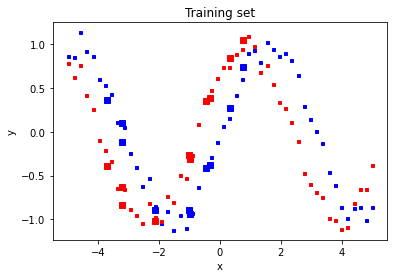

In [52]:
np.random.seed(42)
# Noise free/Noisy training data
nX_tr = 10
std_y = 1e-1 # if noise free set to 1e-4 for numerical stability; corr. var = 1e-16 addition along diagonal
XX = np.random.uniform(low=-4, high=1, size=(nX_tr,1)).reshape(-1,1)
YY = np.concatenate((np.sin(XX), np.sin(XX+np.pi/4)), axis=1) + std_y*np.random.normal(size=(nX_tr,1))

# Test data
nX_te = 50
XX_te = np.linspace(-5, 5, nX_te).reshape(-1,1)
YY_te = np.concatenate((np.sin(XX_te), np.sin(XX_te+np.pi/4)), axis=1) + std_y*np.random.normal(size=(nX_te,1))

# plot
plt.plot(XX, YY[:,0], 'bs', ms=6);
plt.plot(XX, YY[:,1], 'rs', ms=6);
plt.plot(XX_te, YY_te[:,0], 'bs', ms=3);
plt.plot(XX_te, YY_te[:,1], 'rs', ms=3);
plt.xlabel('x');
plt.ylabel('y');
plt.title('Training set');

## Posterior model considering the processes jointly

The posterior is formed as for single-output GPs by conditioning the prior over functions on the training data.

### Single-output quantities 

In [53]:
amplitude = 1; length_scale=1.8
K = se_kern(XX, XX, amplitude, length_scale)
K_s = se_kern(XX, XX_te, amplitude, length_scale)
K_ss = se_kern(XX_te, XX_te, amplitude, length_scale)
K_y = np.array([[0.35, 0.25], [0.25, 0.5]]) # output kernel (true)
SIG_y = (std_y**2)*np.eye(2)

### Multi-output quantities

The two processes in this example are observed at the same inputs, i.e. we study an isotopic multi-output case, as opposed to a situation where the outputs are observed at different inputs, which is referred to as heterotopic. Because we are studying the isotropic case, the multi-output quantities may conveniently be formed by Kronecker products of the single-output quantities, thus $k_x(x,x') k_y(d,d')$ is defined in terms of Kronecker products. Note that in the heterotrophic case $k_x(x,x') k_y(d,d')$ is defined in terms of tensor products, as $k_x(x,x')$ is defined for the specific combination of outputs, and not just repeated for all output combinations as for the isotropic case.

In [54]:
KK = np.kron(K_y,K) # compined Gram matrix
KK_s = np.kron(K_y,K_s)
KK_ss = np.kron(K_y,K_ss)
SIG_KK = np.kron( SIG_y , np.eye(nX_tr) )
Y_c = YY.ravel('F')[:, None]

### Posterior predictive distribution

95\% Bayesian credible interval of the posterior model.

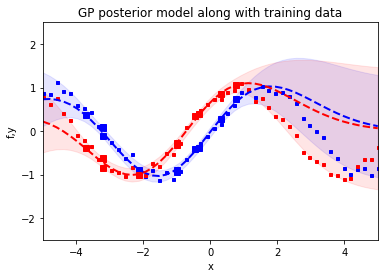

In [55]:
# Apply the kernel function to our training points
L_KKy = np.linalg.cholesky(KK + SIG_KK)
invL_KKy = np.linalg.inv(L_KKy)
invKKy = invL_KKy.T.dot(invL_KKy) # invK = invL^T invL

# predictive mean
MU_c = KK_s.T.dot( invKKy ).dot( Y_c )
COV_c = KK_ss - (KK_s.T.dot( invKKy )).dot( KK_s )
STD_c = np.sqrt( np.diag(COV_c) )

MU = MU_c.reshape((2,nX_te)).T
STD = STD_c.reshape((2,nX_te)).T

plt.figure()
plt.plot(XX, YY[:,0], 'bs', ms=6);
plt.plot(XX, YY[:,1], 'rs', ms=6);
plt.plot(XX_te, YY_te[:,0], 'bs', ms=3);
plt.plot(XX_te, YY_te[:,1], 'rs', ms=3);
plt.fill_between(x=XX_te[:,0], y1=MU[:,0]-2*STD[:,0], y2=MU[:,0]+2*STD[:,0], alpha=0.1, color='blue');
plt.plot(XX_te, MU[:,0], 'b--', lw=2)
plt.fill_between(x=XX_te[:,0], y1=MU[:,1]-2*STD[:,1], y2=MU[:,1]+2*STD[:,1], alpha=0.1, color='red');
plt.plot(XX_te, MU[:,1], 'r--', lw=2)
plt.axis([-5, 5, -2.5, 2.5]);
plt.xlabel('x')
plt.ylabel('f,y')
plt.title('GP posterior model along with training data');
# plt.show()

As we have considered a zero mean function for the processes, the predictions will simply approach zero, as the distance to the training examples gets larger, see e.g. x=5, thus this model should only be use as an interpolator or for extrapolation near the training points, as is also apparent from the plot.

## Posterior model considering the processes separately

95\% Bayesian credible interval of the posterior model.

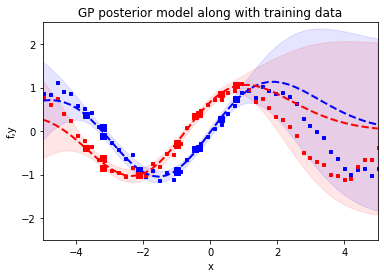

In [56]:
# Apply the kernel function to our training points
Ky = K + (sig_y**2)*np.eye(nX_tr)
Ly = np.linalg.cholesky(Ky)

# inverse of covariance
invLy = np.linalg.inv(Ly)
invKy = invLy.T.dot(invLy) # invK = invL^T invL

# alpha
alp_y1 = invKy.dot(YY[:,0])
alp_y2 = invKy.dot(YY[:,1])

# predictive mean
mu_pos1 = np.dot(K_s.T, alp_y1)
mu_pos2 = np.dot(K_s.T, alp_y2)

# predictive variance
vv_m = np.linalg.solve(Ly,K_s)
cov_pos = K_ss - vv_m.T.dot(vv_m)
std_pos = (np.diag(cov_pos)**(0.5)).reshape(-1,1) # may need abs as variance is zero at training points (no error), which may be 

plt.figure()
plt.plot(XX, YY[:,0], 'bs', ms=6);
plt.plot(XX, YY[:,1], 'rs', ms=6);
plt.plot(XX_te, YY_te[:,0], 'bs', ms=3);
plt.plot(XX_te, YY_te[:,1], 'rs', ms=3);
plt.fill_between(x=XX_te[:,0], y1=mu_pos1-2*std_pos[:,0], y2=mu_pos1+2*std_pos[:,0], alpha=0.1, color='blue');
plt.plot(XX_te, mu_pos1, 'b--', lw=2)
plt.fill_between(x=XX_te[:,0], y1=mu_pos2-2*std_pos[:,0], y2=mu_pos2+2*std_pos[:,0], alpha=0.1, color='red');
plt.plot(XX_te, mu_pos2, 'r--', lw=2)
plt.axis([-5, 5, -2.5, 2.5]);
plt.xlabel('x')
plt.ylabel('f,y')
plt.title('GP posterior model along with training data');
# # plt.show()

Note that the uncertainty bounds are wider when considering the two processes separately! Thus, when the two processes are considered jointly, they borrow statistical power from each other through the output kernel $k_y(d,d')$, which expresses the output correlation.

## Parameter learning: GPy with MLE

Learning of multi-output GPs follow the same approaches as explained for single-output GPs above, so we will simply show how this can be done using GPy to minimize repetition.

### Intrinsic Coregionalization Model (ICM) 

#### Re-structure the data into the format GPy expects

In [57]:
Xgpy = np.vstack([
    np.vstack([XX[:,0], np.ones_like(XX[:,0])*0]).T,
    np.vstack([XX[:,0], np.ones_like(XX[:,0])*1]).T
])
ygpy = np.hstack([
    YY[:,0].T,
    YY[:,1].T
])
ygpy = ygpy.reshape((len(ygpy),1))

#### Define ICM kernel

In [58]:
# icm = GPy.kern.RBF(input_dim=1)**GPy.kern.Coregionalize(input_dim=1,output_dim=2, rank=2)
icm = GPy.util.multioutput.ICM(input_dim=1,num_outputs=2,kernel=GPy.kern.RBF(1),W_rank=2)
display(icm)

ICM.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
B.W,"(2, 2)",,
B.kappa,"(2,)",+ve,


#### Fit model

In [59]:
model = GPy.models.GPRegression(Xgpy, ygpy, icm)
model.optimize_restarts(num_restarts = 10);

Optimization restart 1/10, f = -3.140020806186346
Optimization restart 2/10, f = -3.140020806173222
Optimization restart 3/10, f = -3.140020806186346
Optimization restart 4/10, f = -3.1400208061079447
Optimization restart 5/10, f = -3.1400208054542897
Optimization restart 6/10, f = -3.1400208061690584
Optimization restart 7/10, f = -3.140020806185042
Optimization restart 8/10, f = -3.1400208061856745
Optimization restart 9/10, f = -3.1400208046660936
Optimization restart 10/10, f = -3.14002080618563


In [60]:
out_sy=np.sqrt(model.Gaussian_noise.variance[0]); print(out_sy)
rbf_sf=np.sqrt(model.ICM.rbf.variance[0]); print(rbf_sf)
rbf_lf=(model.ICM.rbf.lengthscale[0]); print(rbf_lf)
coteg_B=model.ICM.B.B; print(coteg_B)

0.07917120780962851
0.7651946499645894
1.7337299086051674
[[1.51577785 0.97167378]
 [0.97167378 1.22905807]]


#### Plot model fit

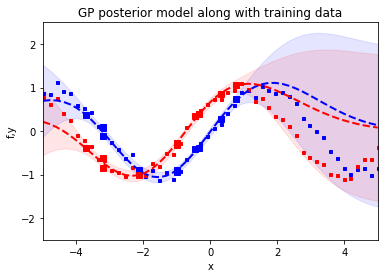

In [61]:
amplitude = rbf_sf; length_scale=rbf_lf
K = se_kern(XX, XX, amplitude, length_scale)
K_s = se_kern(XX_te, XX, amplitude, length_scale)
K_ss = se_kern(XX_te, XX_te, amplitude, length_scale)
K_y = coteg_B
SIG_y = (out_sy**2)*np.eye(2)

KK = np.kron(K_y,K) # compined Gram matrix
KK_s = np.kron(K_y,K_s)
KK_ss = np.kron(K_y,K_ss)
SIG_KK = np.kron( SIG_y , np.eye(nX_tr) )
Y_c = YY.ravel('F')[:, None]

# Apply the kernel function to our training points
L_KKy = np.linalg.cholesky(KK + SIG_KK)
invL_KKy = np.linalg.inv(L_KKy)
invKKy = invL_KKy.T.dot(invL_KKy) # invK = invL^T invL

# predictive mean
MU_c = KK_s.dot( invKKy ).dot( Y_c )
COV_c = KK_ss - (KK_s.dot( invKKy )).dot( KK_s.T )
STD_c = np.sqrt( np.diag(COV_c) )

MU = MU_c.reshape((2,nX_te)).T
STD = STD_c.reshape((2,nX_te)).T

plt.figure()
plt.plot(XX, YY[:,0], 'bs', ms=6);
plt.plot(XX, YY[:,1], 'rs', ms=6);
plt.plot(XX_te, YY_te[:,0], 'bs', ms=3);
plt.plot(XX_te, YY_te[:,1], 'rs', ms=3);
plt.fill_between(x=XX_te[:,0], y1=MU[:,0]-2*STD[:,0], y2=MU[:,0]+2*STD[:,0], alpha=0.1, color='blue');
plt.plot(XX_te, MU[:,0], 'b--', lw=2)
plt.fill_between(x=XX_te[:,0], y1=MU[:,1]-2*STD[:,1], y2=MU[:,1]+2*STD[:,1], alpha=0.1, color='red');
plt.plot(XX_te, MU[:,1], 'r--', lw=2)
plt.axis([-5, 5, -2.5, 2.5]);
plt.xlabel('x')
plt.ylabel('f,y')
plt.title('GP posterior model along with training data');
# # plt.show()

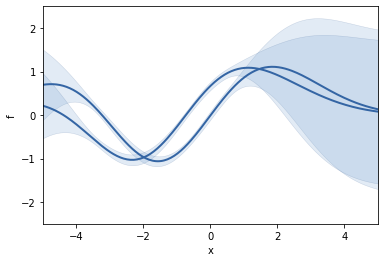

In [62]:
# Build-in GPy function
fig, ax = plt.subplots()
for i in range(2):
    model.plot_latent(fignum=1,plot_limits=np.array([-5,5]),fixed_inputs=[(1, i)],ax=ax,legend=False)
plt.xlabel('x')
plt.ylabel('f')
plt.ylim([-2.5, 2.5]);
# plt.grid();

### Independent models

#### Define and fit models

In [63]:
model1 = GPy.models.GPRegression(XX,YY[:,0].reshape(-1,1))
model2 = GPy.models.GPRegression(XX,YY[:,1].reshape(-1,1))

model1.optimize_restarts(num_restarts = 5);
model2.optimize_restarts(num_restarts = 5);

Optimization restart 1/5, f = -0.48918739810105905
Optimization restart 2/5, f = -0.4891873981105217
Optimization restart 3/5, f = -0.489187398114713
Optimization restart 4/5, f = -0.4891873981144812
Optimization restart 5/5, f = -0.4891873981142991
Optimization restart 1/5, f = -1.0500999733516387
Optimization restart 2/5, f = -1.0500999733522232
Optimization restart 3/5, f = -1.0500999733522551
Optimization restart 4/5, f = -1.0500999733537038
Optimization restart 5/5, f = -1.0500999733529373


#### Plot model fits

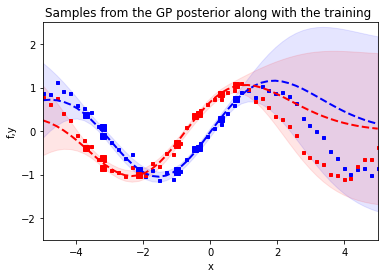

In [64]:
# Model 1
sig_y, sig_f, l_f = np.sqrt(model1.Gaussian_noise.variance[0]), np.sqrt(model1.rbf.variance[0]), model1.rbf.lengthscale[0]
K_s = se_kern(XX, XX_te, sig_f, l_f)
K_ss = se_kern(XX_te, XX_te, sig_f, l_f)
# Apply the kernel function to our training points
Ky = Ky_kern(XX, XX, sig_y, sig_f, l_f)
Ly = np.linalg.cholesky(Ky)
# inverse of covariance
invLy = np.linalg.inv(Ly)
invKy = invLy.T.dot(invLy) # invK = invL^T invL
# alpha
alp_y = invKy.dot(YY[:,0].reshape(-1,1))
# predictive mean
mu_pos1 = np.dot(K_s.T, alp_y)
# predictive variance
vv_m = np.linalg.solve(Ly,K_s)
cov_pos = K_ss - vv_m.T.dot(vv_m)
std_pos1 = (np.diag(cov_pos)**(0.5)).reshape(-1,1) # may need abs as variance is zero at training points (no error), which may be encoded as -0 (no allowed)

# Model 2
sig_y, sig_f, l_f = np.sqrt(model2.Gaussian_noise.variance[0]), np.sqrt(model2.rbf.variance[0]), model2.rbf.lengthscale[0]
K_s = se_kern(XX, XX_te, sig_f, l_f)
K_ss = se_kern(XX_te, XX_te, sig_f, l_f)
# Apply the kernel function to our training points
Ky = Ky_kern(XX, XX, sig_y, sig_f, l_f)
Ly = np.linalg.cholesky(Ky)
# inverse of covariance
invLy = np.linalg.inv(Ly)
invKy = invLy.T.dot(invLy) # invK = invL^T invL
# alpha
alp_y = invKy.dot(YY[:,1].reshape(-1,1))
# predictive mean
mu_pos2 = np.dot(K_s.T, alp_y)
# predictive variance
vv_m = np.linalg.solve(Ly,K_s)
cov_pos = K_ss - vv_m.T.dot(vv_m)
std_pos2 = (np.diag(cov_pos)**(0.5)).reshape(-1,1) # may need abs as variance is zero at training points (no error), which may be encoded as -0 (no allowed)

# Plot
plt.figure()
plt.plot(XX, YY[:,0], 'bs', ms=6);
plt.plot(XX, YY[:,1], 'rs', ms=6);
plt.plot(XX_te, YY_te[:,0], 'bs', ms=3);
plt.plot(XX_te, YY_te[:,1], 'rs', ms=3);
plt.fill_between(x=XX_te[:,0], y1=mu_pos1[:,0]-2*std_pos1[:,0], y2=mu_pos1[:,0]+2*std_pos1[:,0], alpha=0.1, color='blue');
plt.plot(XX_te, mu_pos1, 'b--', lw=2)
plt.fill_between(x=XX_te[:,0], y1=mu_pos2[:,0]-2*std_pos2[:,0], y2=mu_pos2[:,0]+2*std_pos2[:,0], alpha=0.1, color='red');
plt.plot(XX_te, mu_pos2, 'r--', lw=2)
plt.axis([-5, 5, -2.5, 2.5]);
plt.xlabel('x')
plt.ylabel('f,y')
plt.title('Samples from the GP posterior along with the training ');
# plt.show()

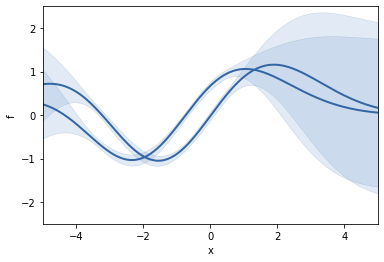

In [65]:
# Build-in GPy function
fig, ax = plt.subplots()
model1.plot_latent(fignum=1,plot_limits=np.array([-5,5]),ax=ax, legend=False)
model2.plot_latent(fignum=1,plot_limits=np.array([-5,5]),ax=ax, legend=False)
plt.xlabel('x')
plt.ylabel('f')
plt.ylim([-2.5, 2.5]);
# plt.grid();

Note again that the uncertainty bounds are wider, within the range of the training data, when considering the two processes separately! Thus, when the two processes are considered jointly, they borrow statistical power from each other through the output kernel $k_y(d,d')$, which expresses the output correlation, as well as through parameters sharing in a learning setting. Again, as we have considered a zero-mean function for the processes in all examples, the predictions will simply approach zero, as the distance to the training examples gets larger, see e.g. x=5.